**<center><font size=5>Brain Tumor Detection with Transefer Learning </font></center>**
***


# <a id='env'>Setting up the Environment</a>

In [ ]:
from IPython.display import clear_output
!pip install imutils
clear_output()

from keras.applications.vgg19 import VGG19,preprocess_input
from keras.applications.xception import Xception,preprocess_input
from keras.applications.inception_v3 import InceptionV3,inception_v3
from keras.applications.resnet50 import ResNet50,resnet50


In [2]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [3]:
!apt-get install tree
#clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 12 not upgraded.
Need to get 46.1 kB of archives.
After this operation, 106 kB of additional disk space will be used.
Err:1 http://deb.debian.org/debian stretch/main amd64 tree amd64 1.7.0-5
  404  Not Found
E: Failed to fetch http://deb.debian.org/debian/pool/main/t/tree/tree_1.7.0-5_amd64.deb  404  Not Found
E: Unable to fetch some archives, maybe run apt-get update or try with --fix-missing?
/bin/sh: 1: tree: not found


In [4]:
IMG_PATH = '../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

# <a id='import'>Data Import and Preprocessing</a>

In [5]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [6]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00, 19.09it/s]

193 images loaded from TRAIN/ directory.
10 images loaded from TEST/ directory.
50 images loaded from VAL/ directory.


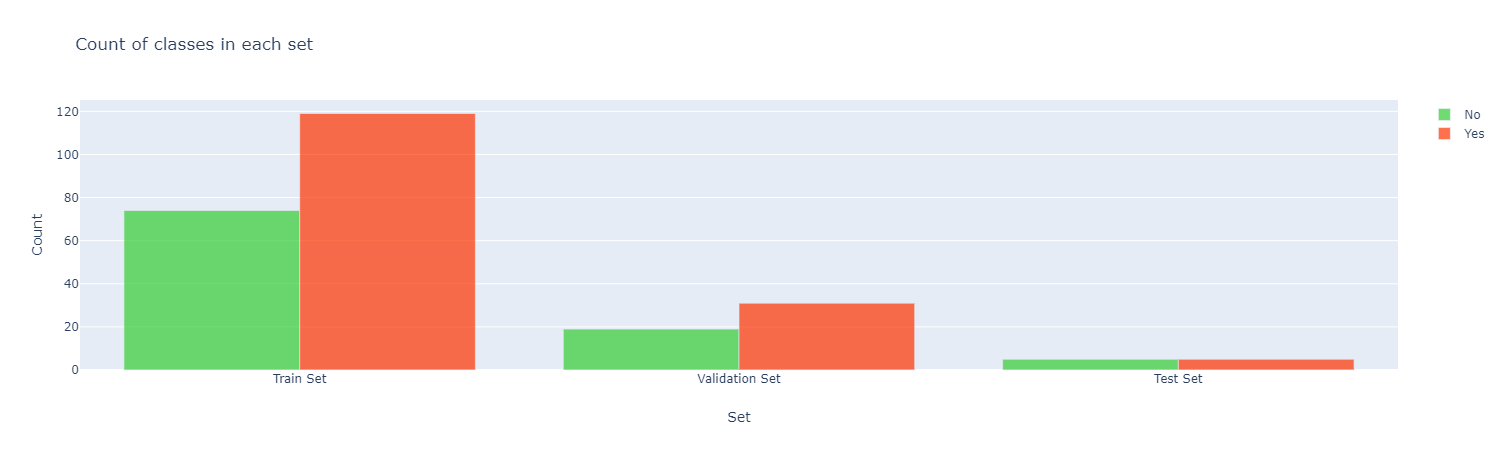

In [7]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [8]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

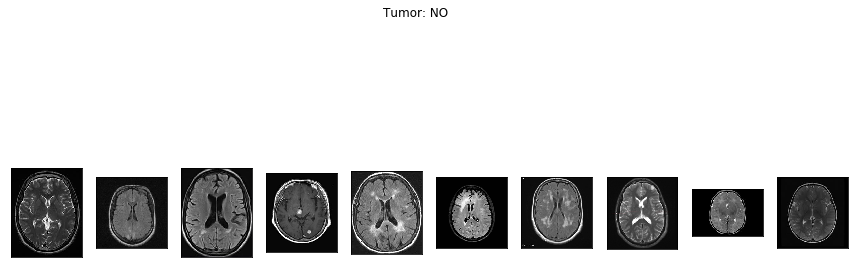

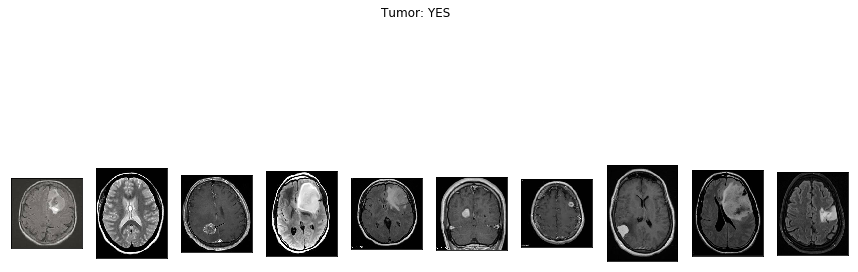

In [9]:
plot_samples(X_train, y_train, labels, 10)

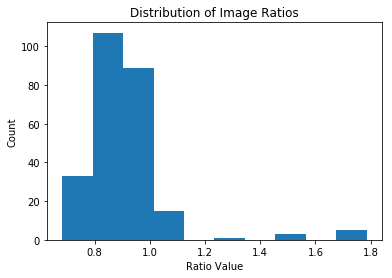

In [10]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [11]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [12]:
img = cv2.imread('../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

In [14]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

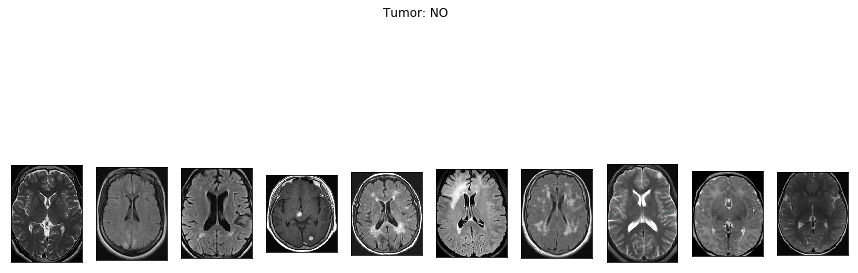

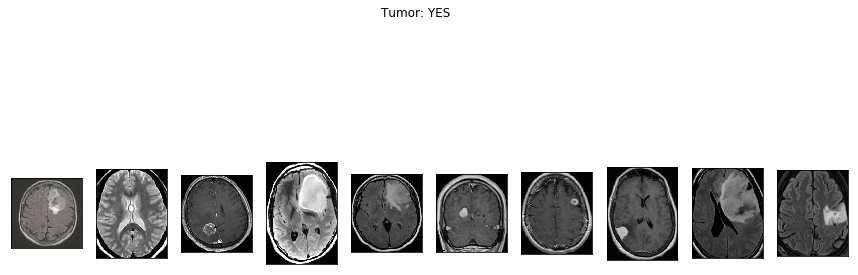

In [15]:
plot_samples(X_train_crop, y_train, labels, 10)

In [16]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [17]:

!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [18]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [19]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

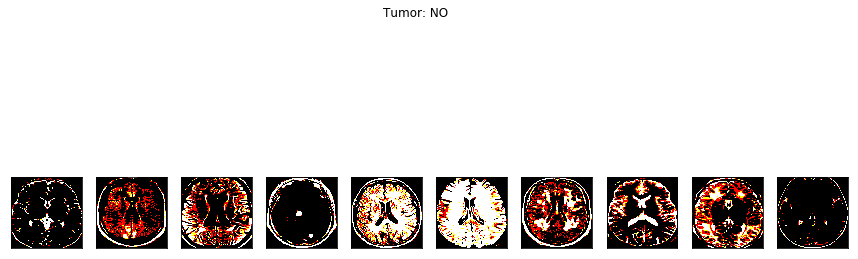

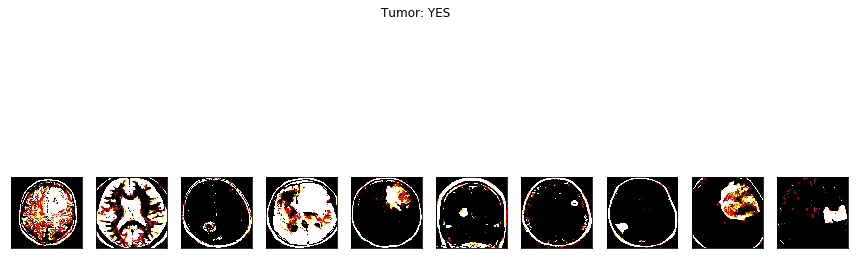

In [20]:
 plot_samples(X_train_prep, y_train, labels, 10)

In [21]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [22]:
os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

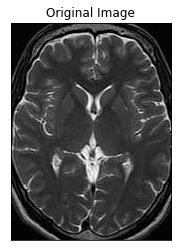

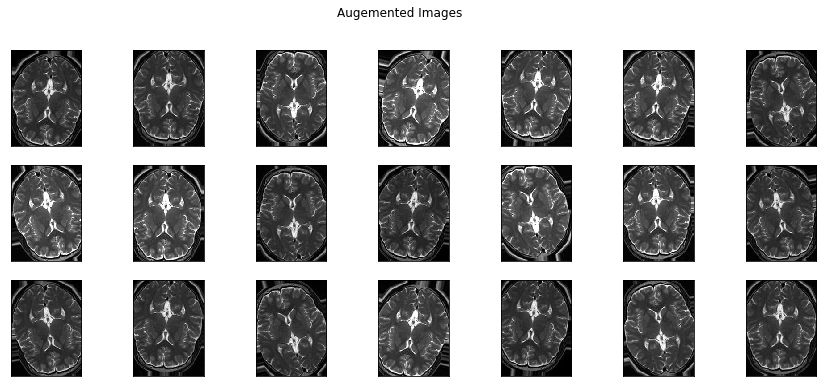

In [23]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [24]:
!rm -rf preview/

### <a id='apply'>Apply</a>

In [25]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [26]:

# load base model
ResNet50_weight_path = '../input/keras-pretrained-models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
resnet50_x = ResNet50(
    weights=ResNet50_weight_path,
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning:

The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.



In [27]:
# load base model
InceptionV3_weight_path = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
inceptionV3 = InceptionV3(
     weights=InceptionV3_weight_path,
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

In [28]:
# load base model
vgg16_weight_path = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

In [29]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import cv2
import matplotlib.pyplot as plt
import os
import seaborn as sns
import umap
from PIL import Image
from scipy import misc
from os import listdir
from os.path import isfile, join
import numpy as np
from scipy import misc
from random import shuffle
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from keras.layers import Input


In [30]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras


# VGG-16 

In [32]:
# plot feature map of first conv layer for given image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot 
from numpy import expand_dims


f = plt.figure(figsize=(16,16))
# load the modelf = plt.figure(figsize=(10,3))
model = VGG16()
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[1].output)
model.summary()
# load the image with the required shape
# convert the image to an array
img = img_to_array(X_val_prep[43])
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
# 		ax = pyplot.subplot(square, square, ix)
# 		ax.set_xticks([])
# 		ax.set_yticks([])
		# plot filter channel in grayscale
# 		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='viridis')
		ix += 1
# show the figure
pyplot.show()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


<Figure size 1152x1152 with 0 Axes>

In [33]:


NUM_CLASSES = 1

vgg16 = Sequential()
vgg16.add(vgg)
vgg16.add(layers.Dropout(0.3))
vgg16.add(layers.Flatten())
vgg16.add(layers.Dropout(0.5))
vgg16.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

vgg16.layers[0].trainable = False

vgg16.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)
vgg16.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=["accuracy"])

vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


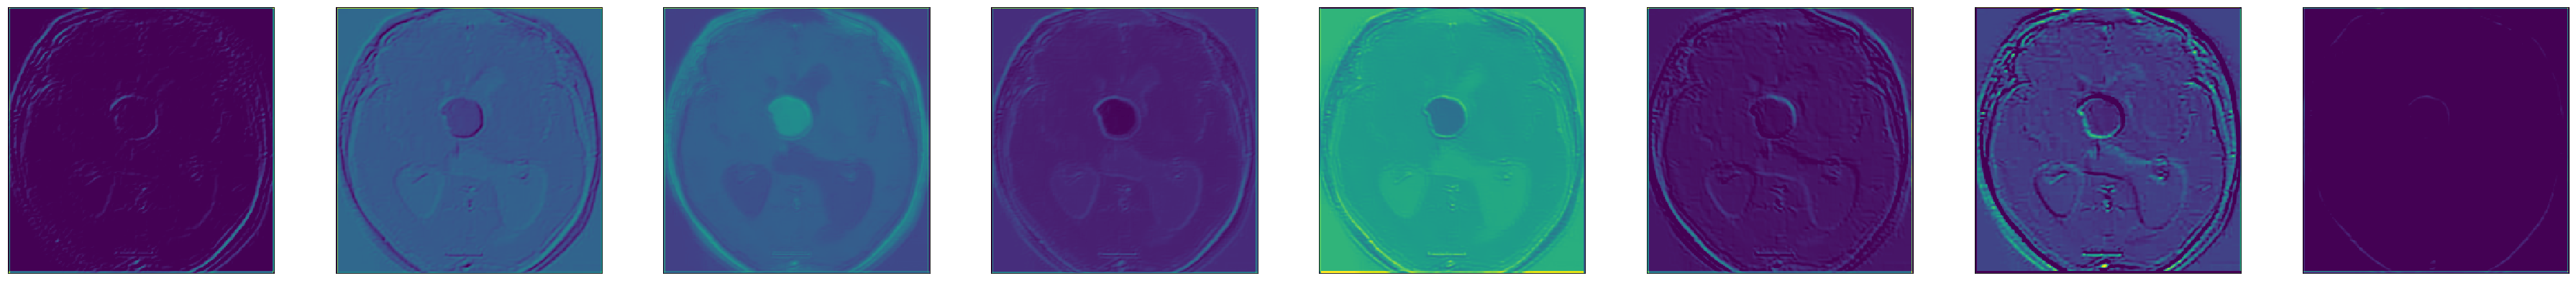

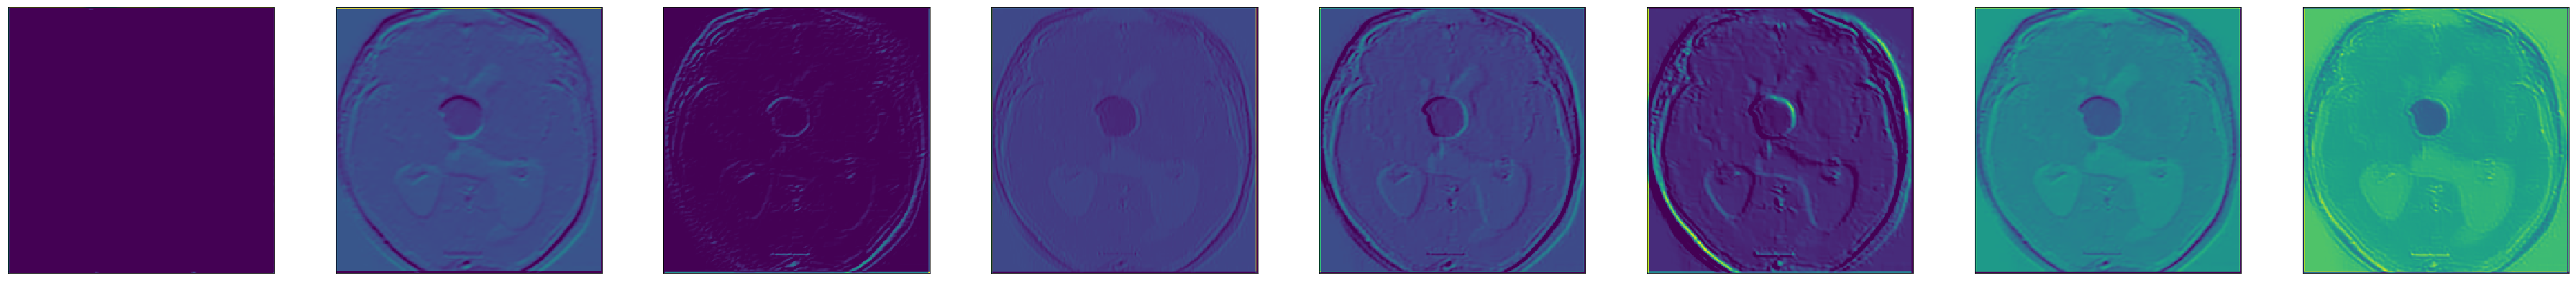

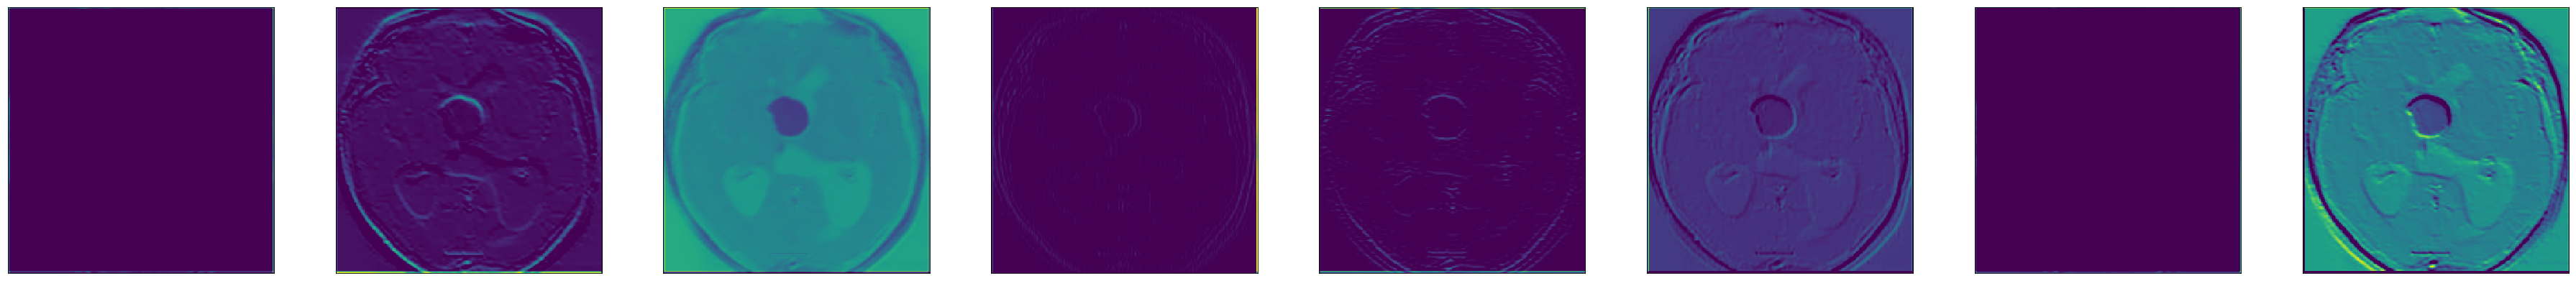

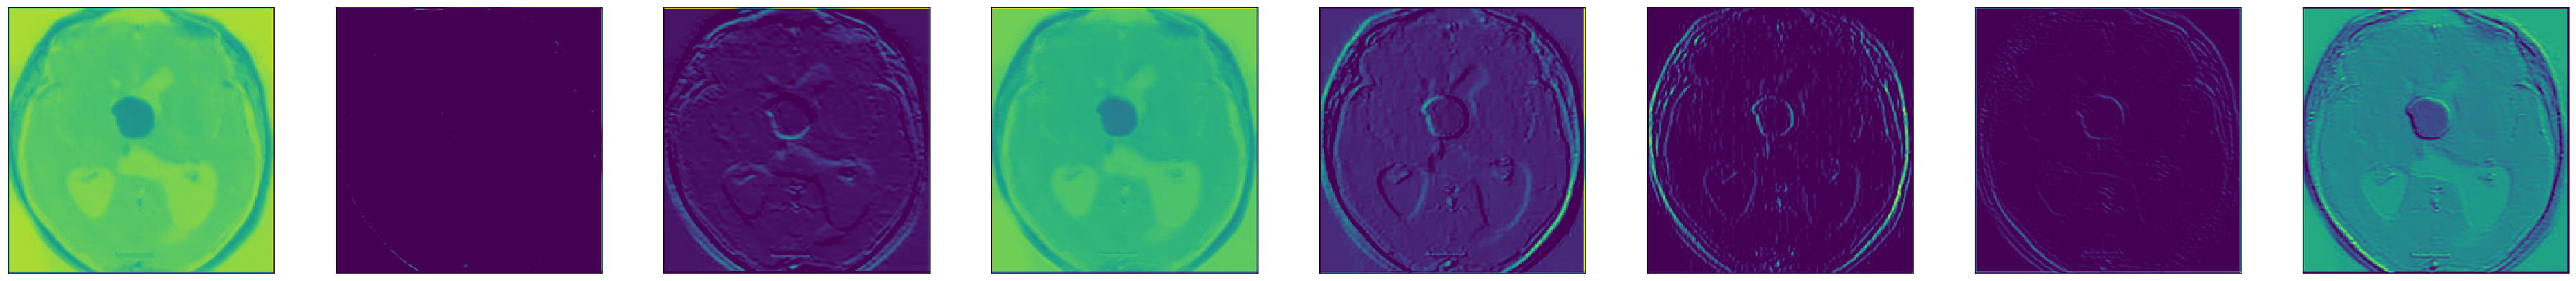

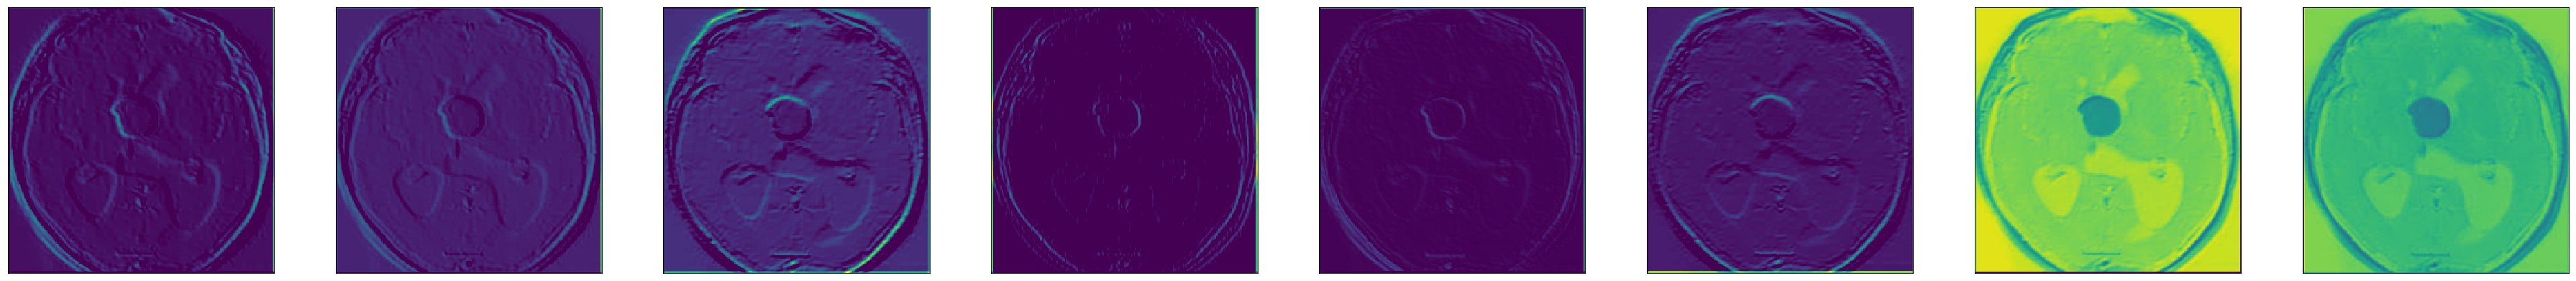

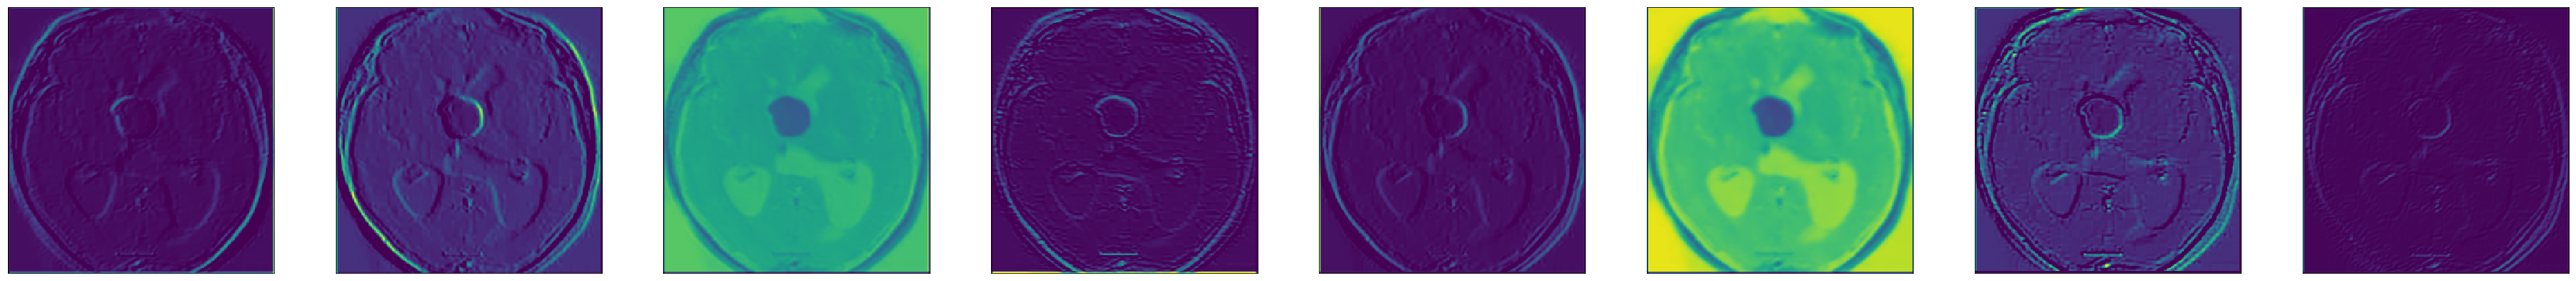

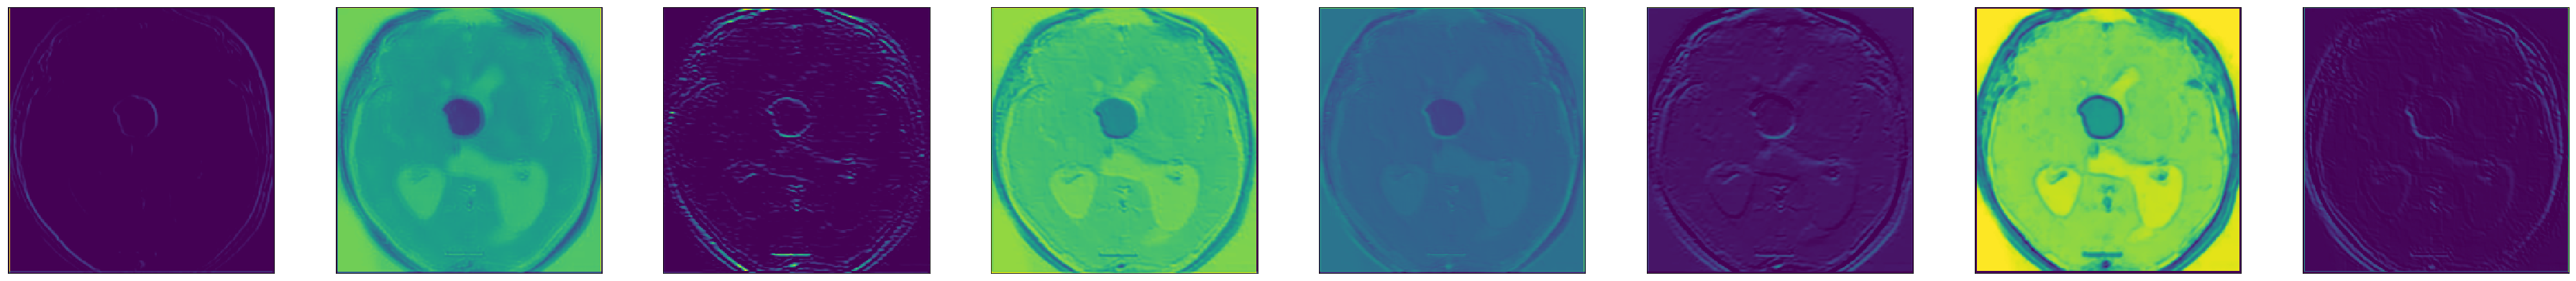

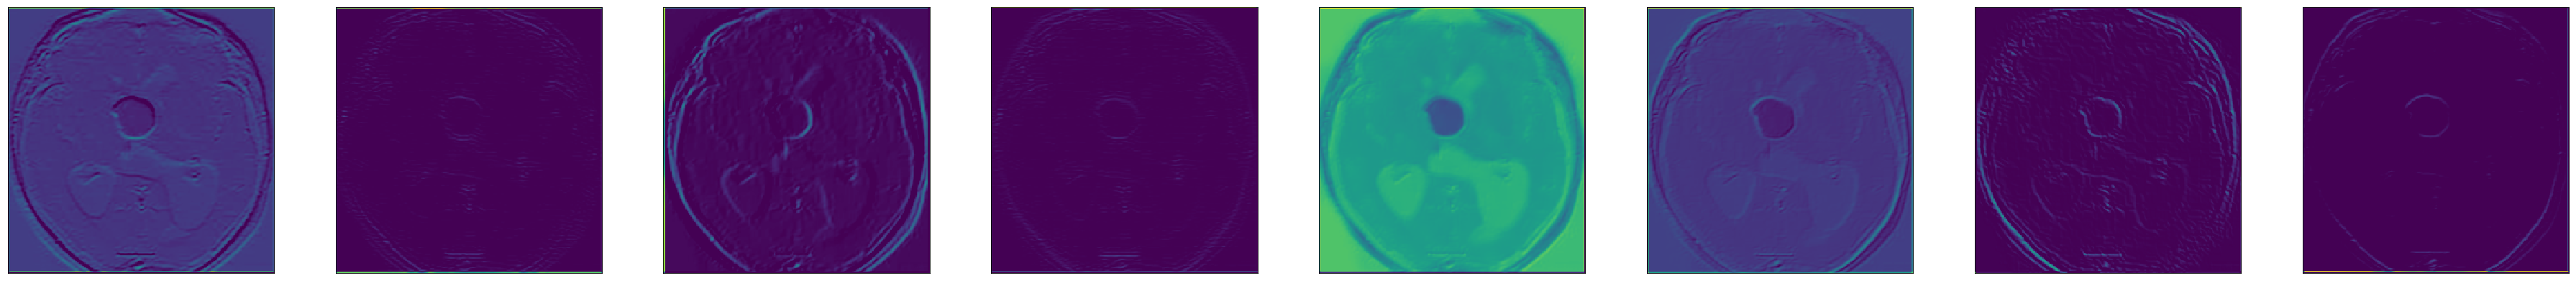

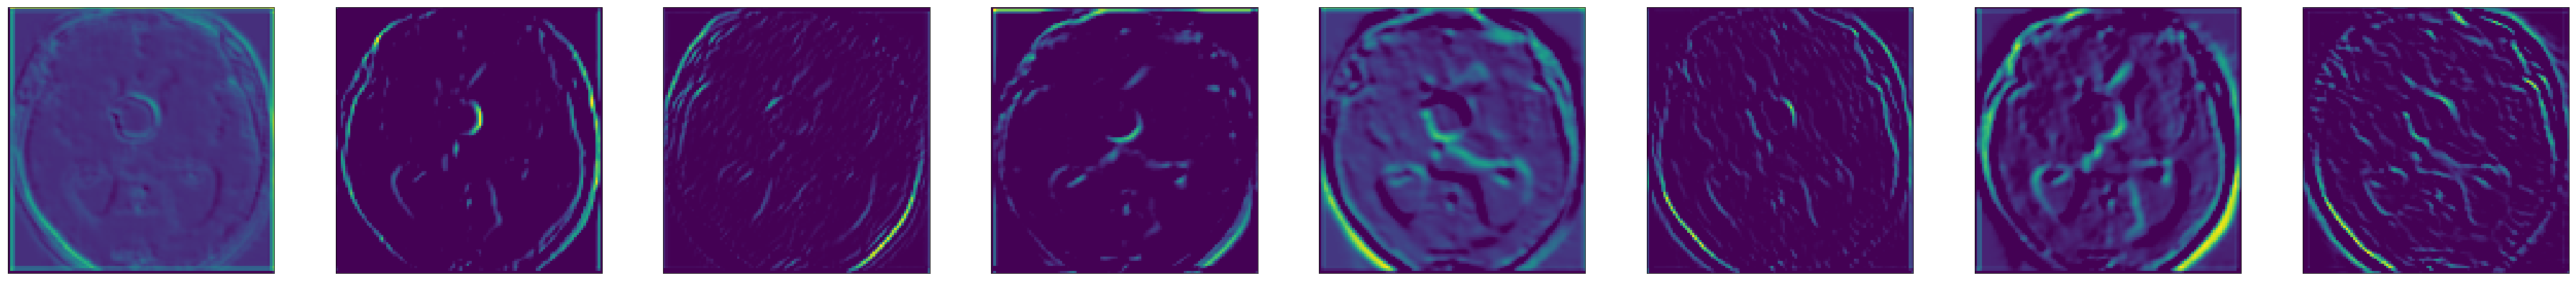

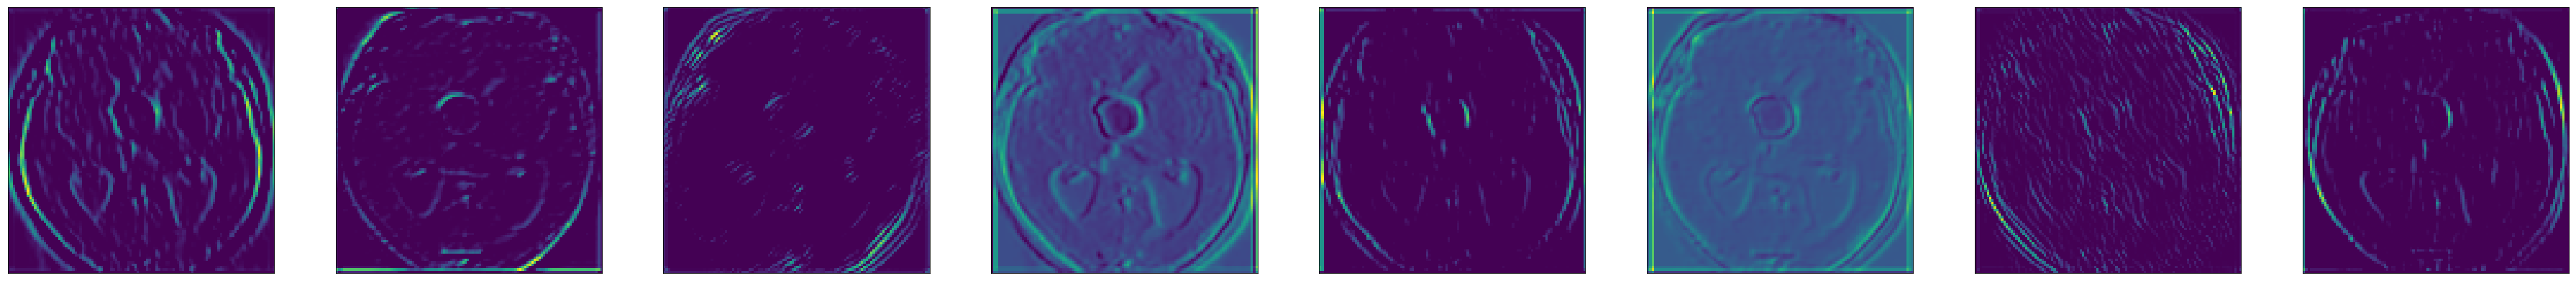

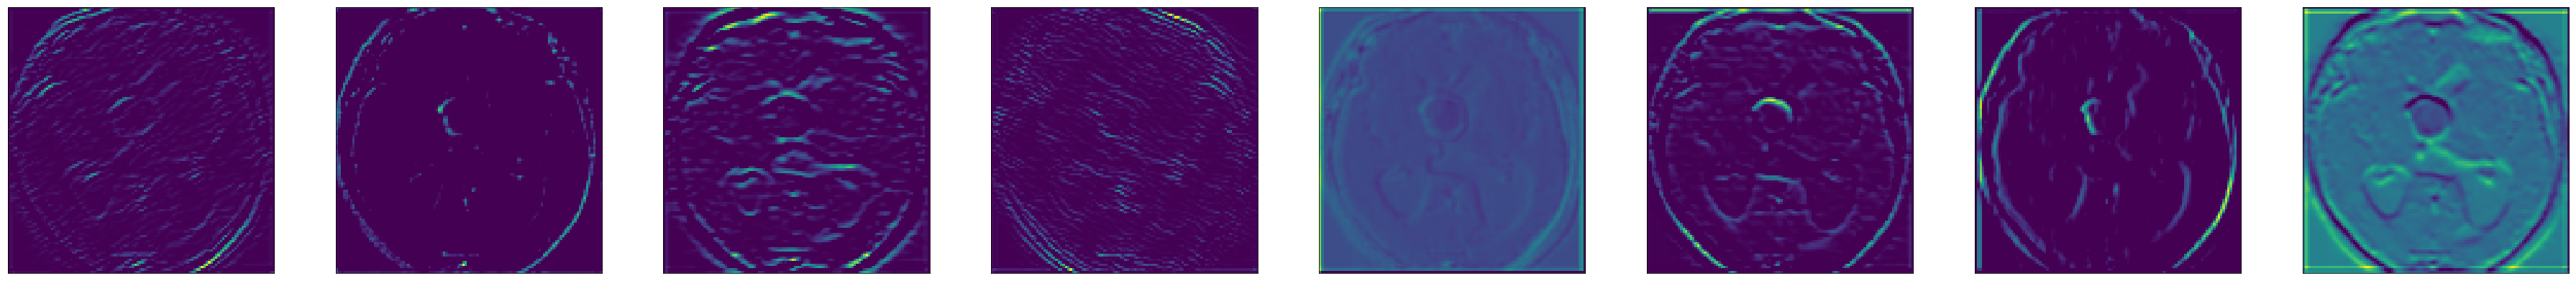

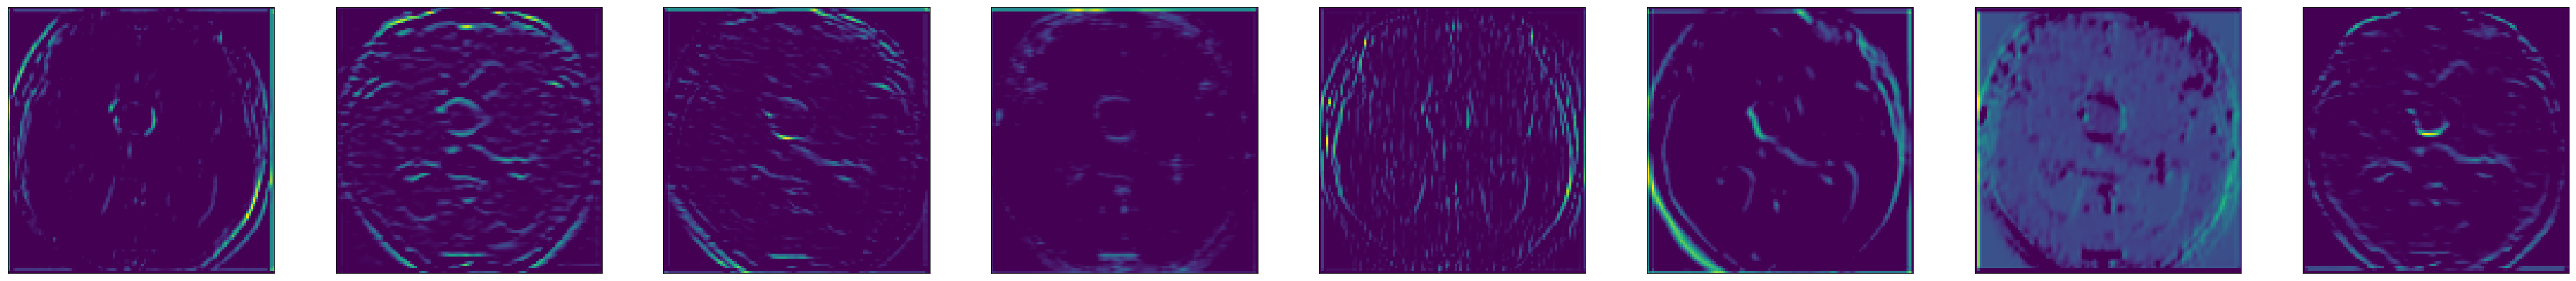

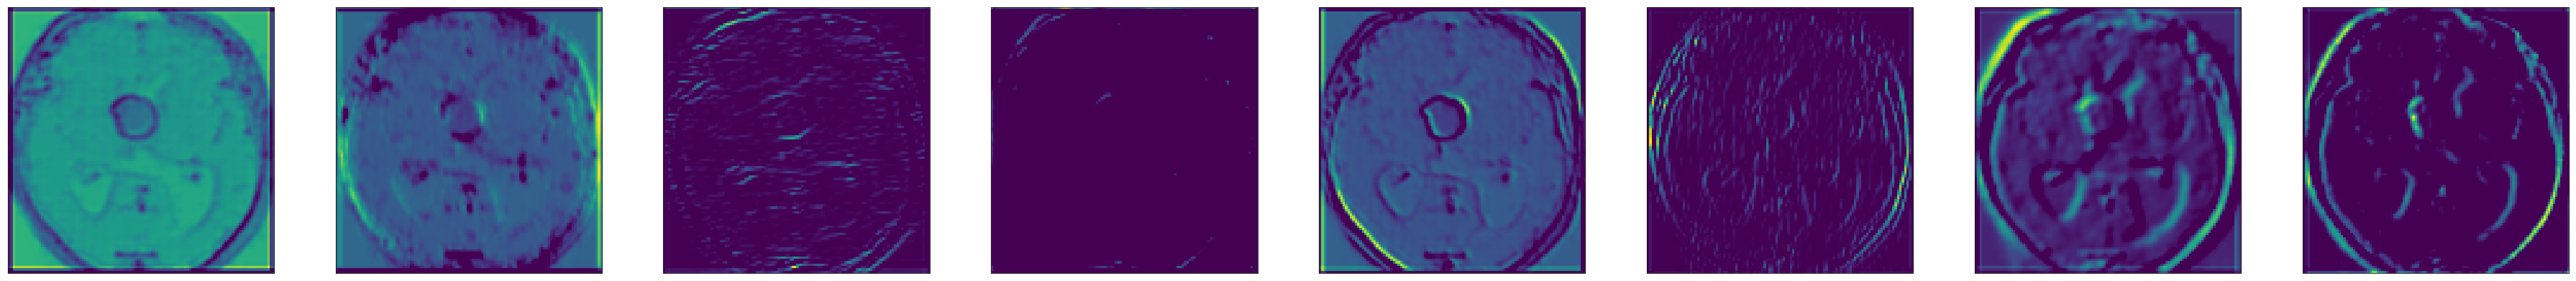

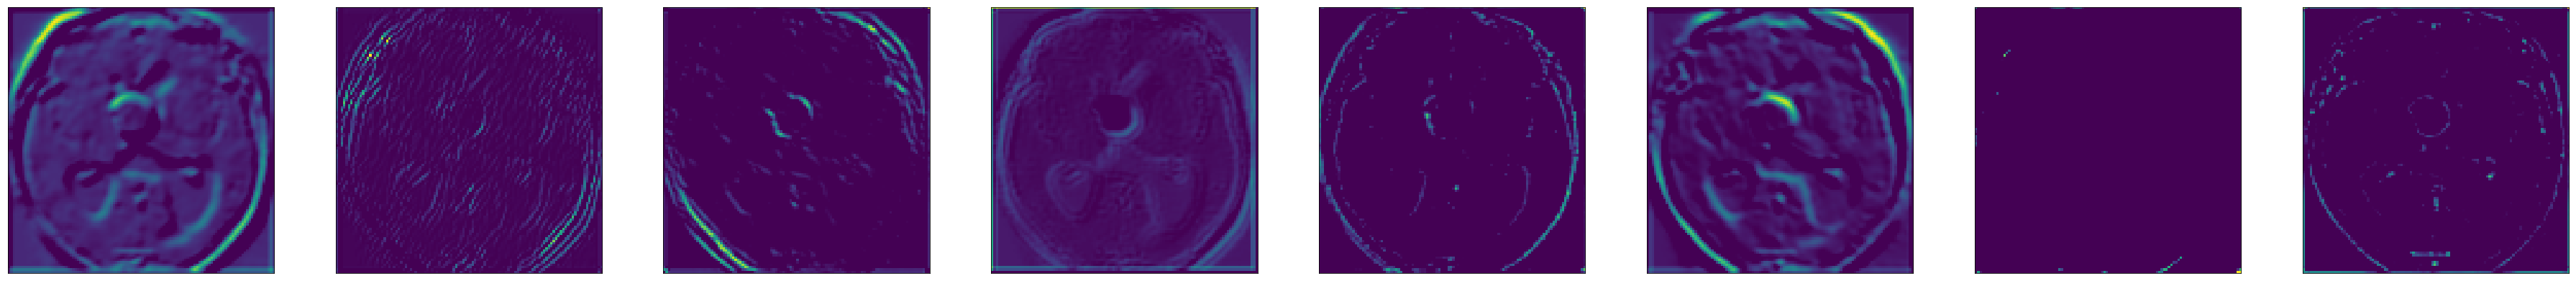

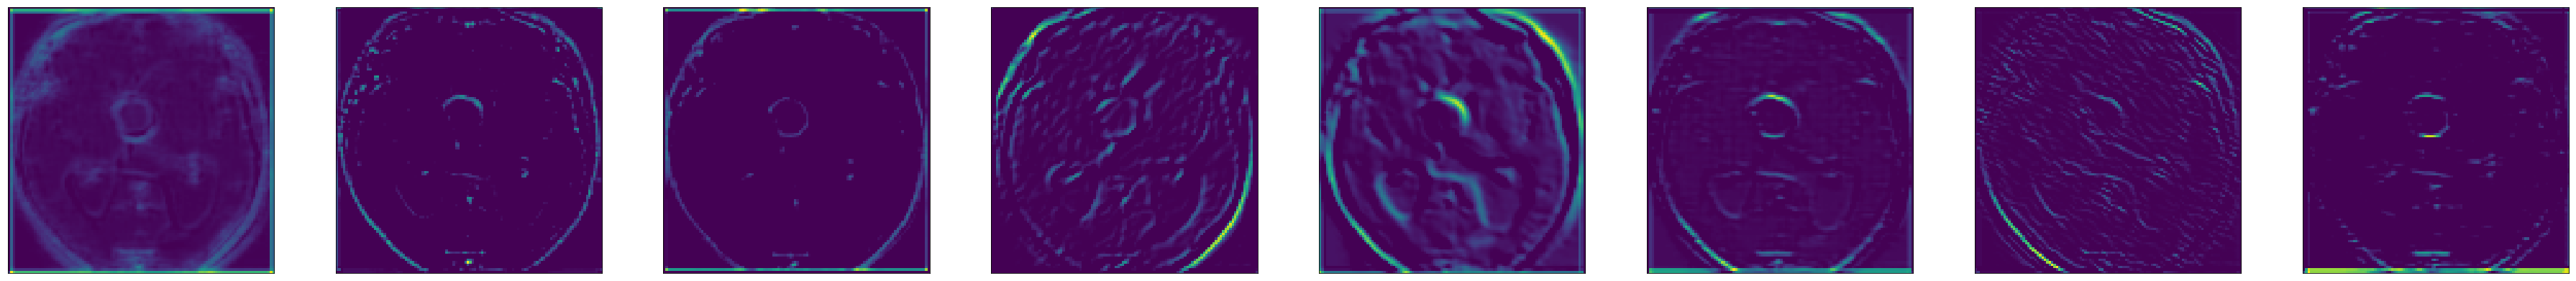

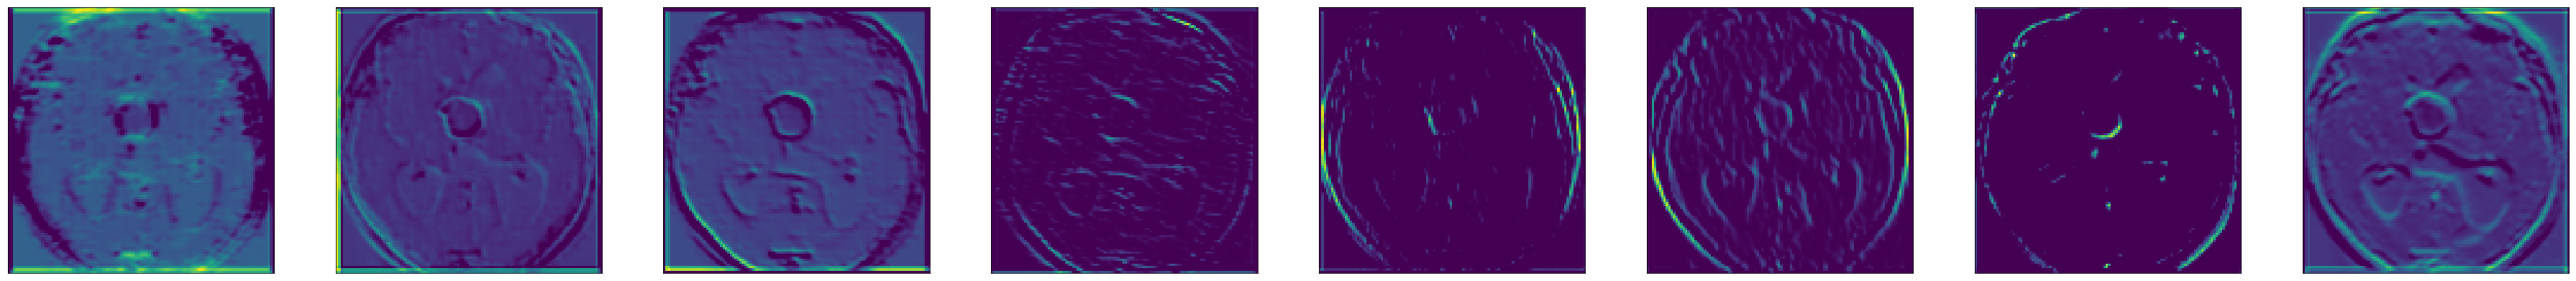

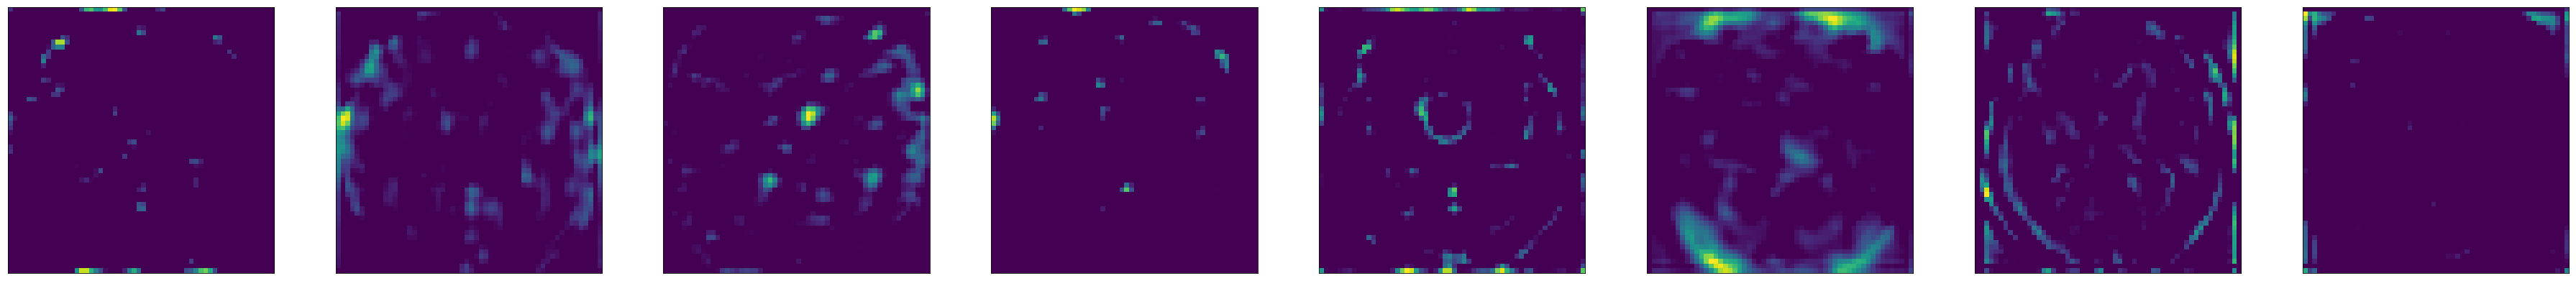

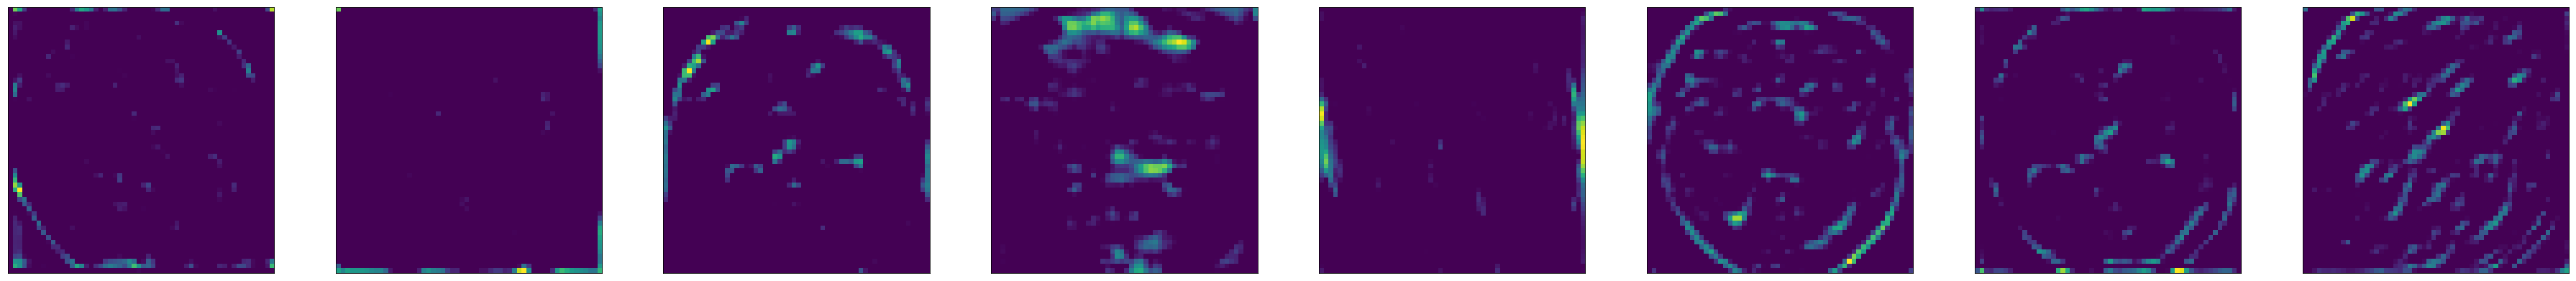

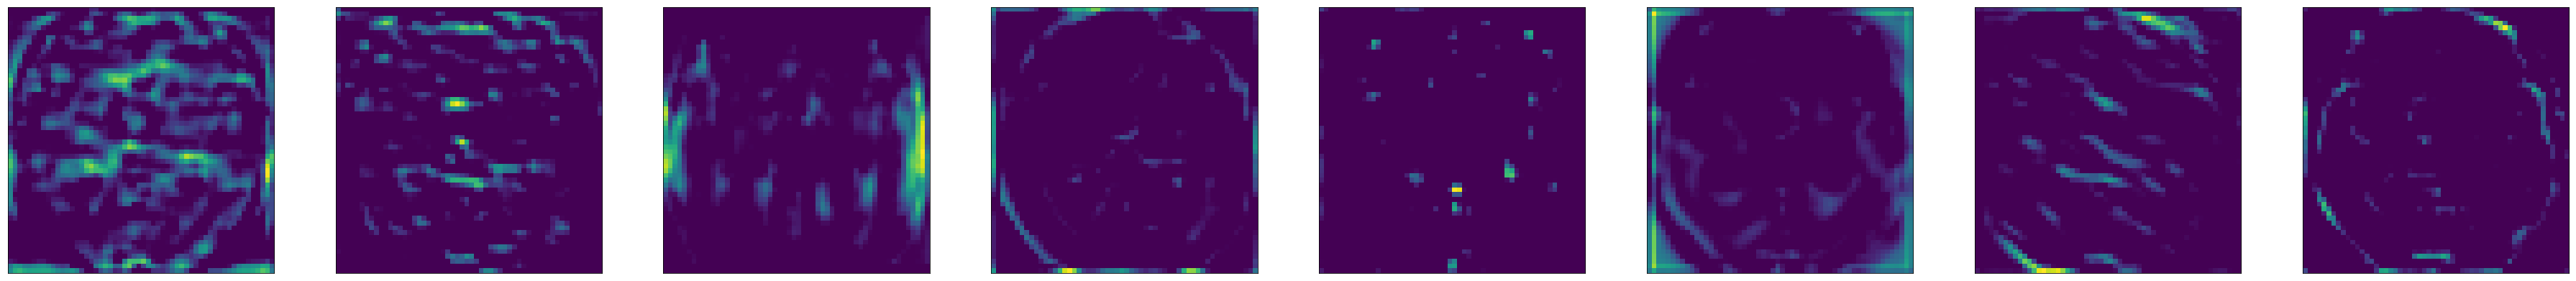

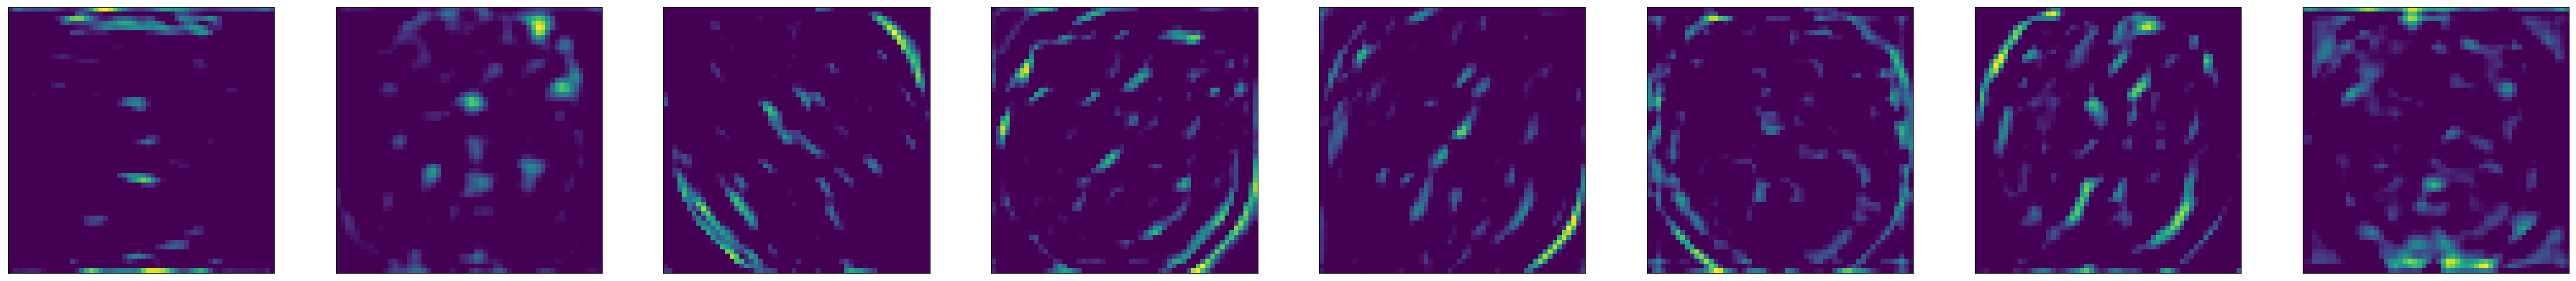

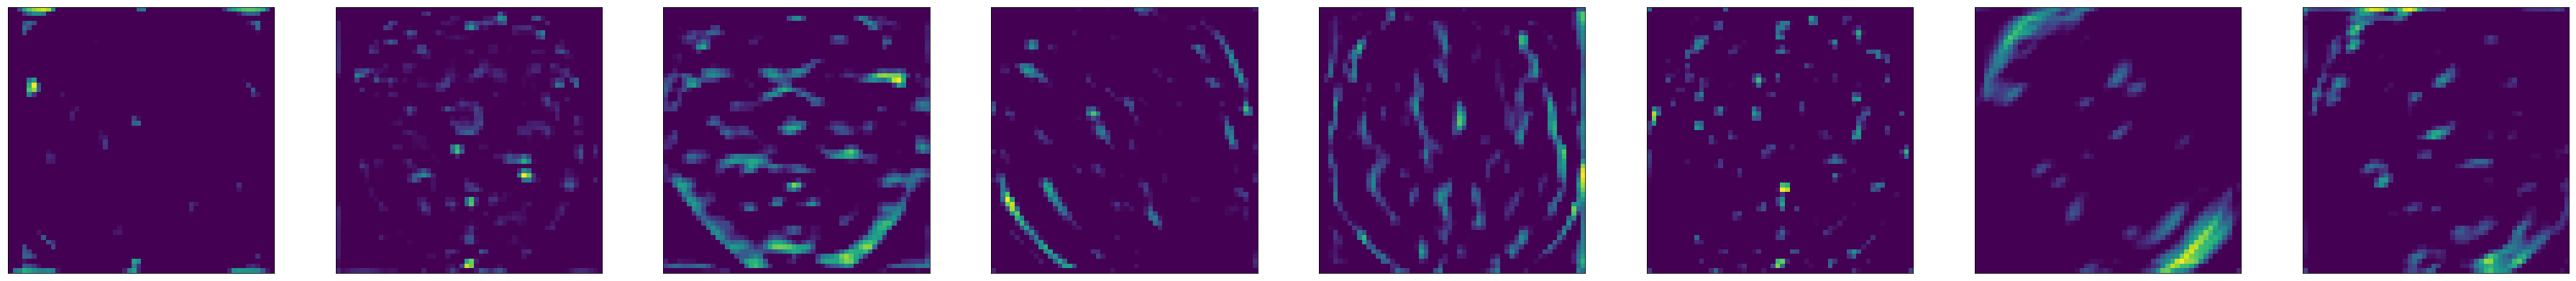

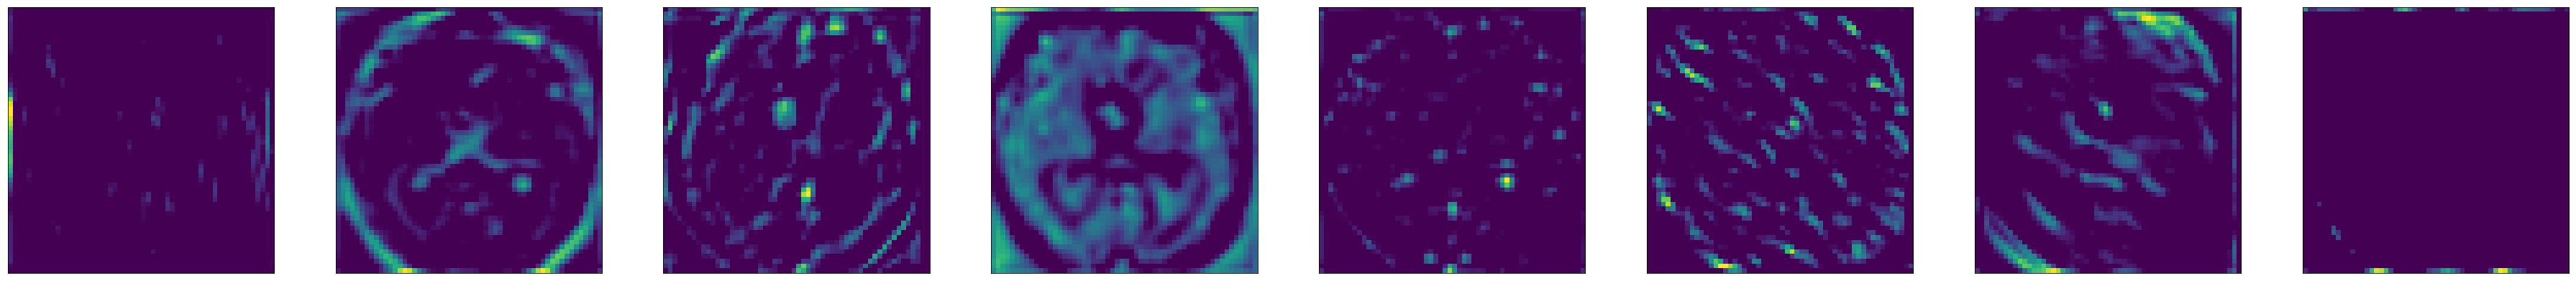

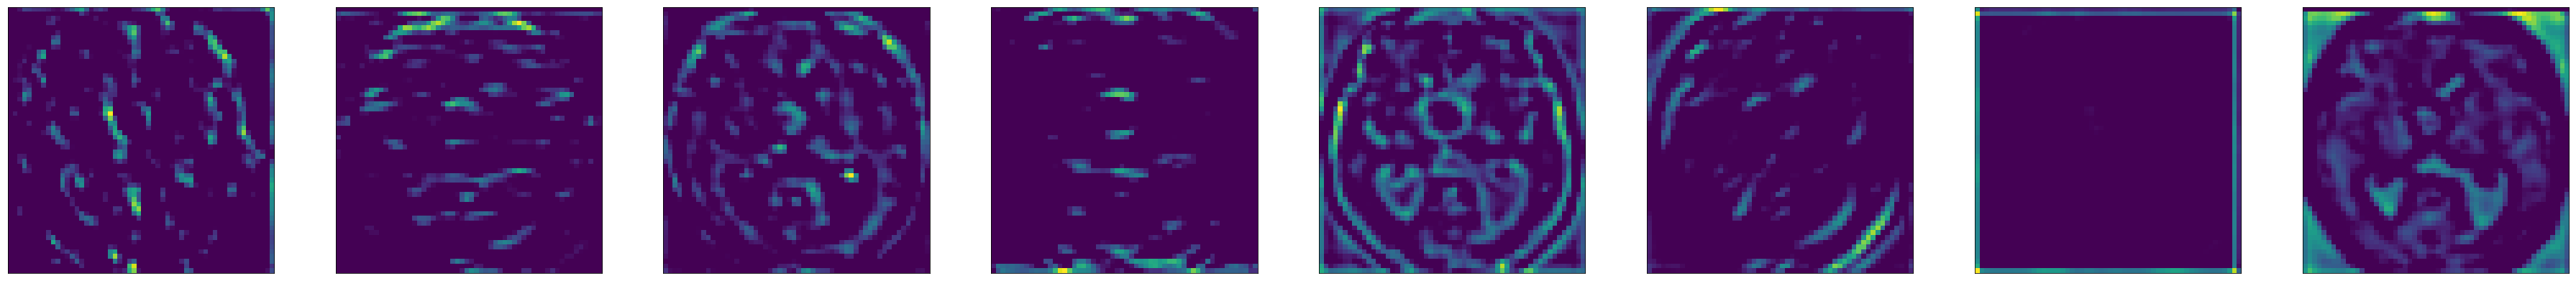

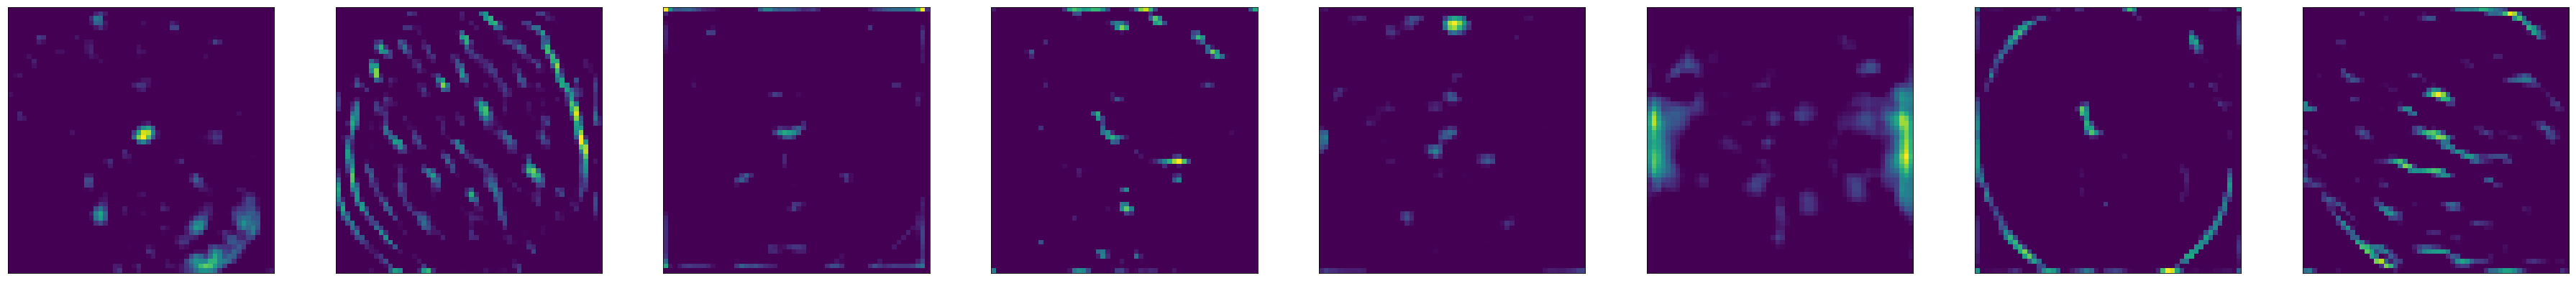

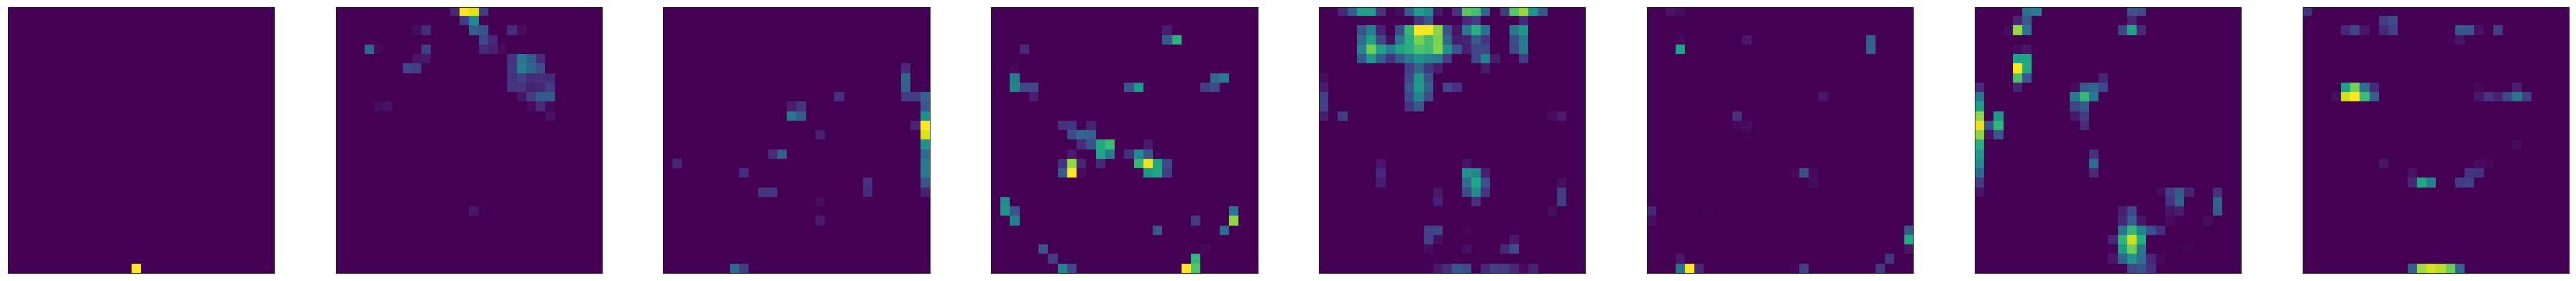

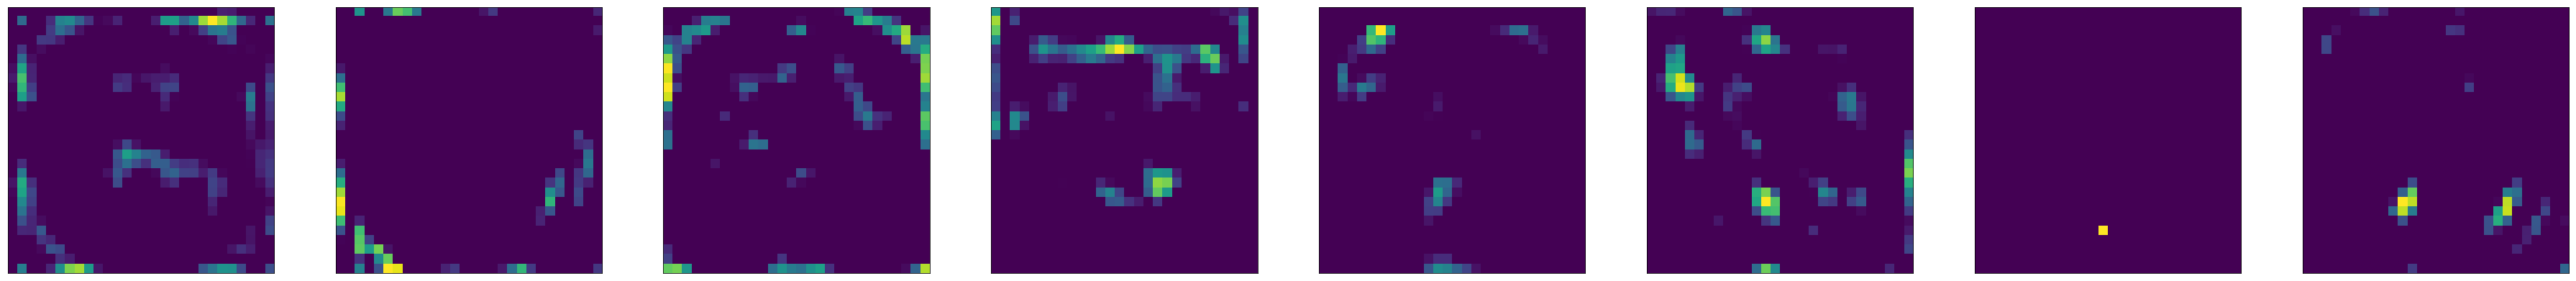

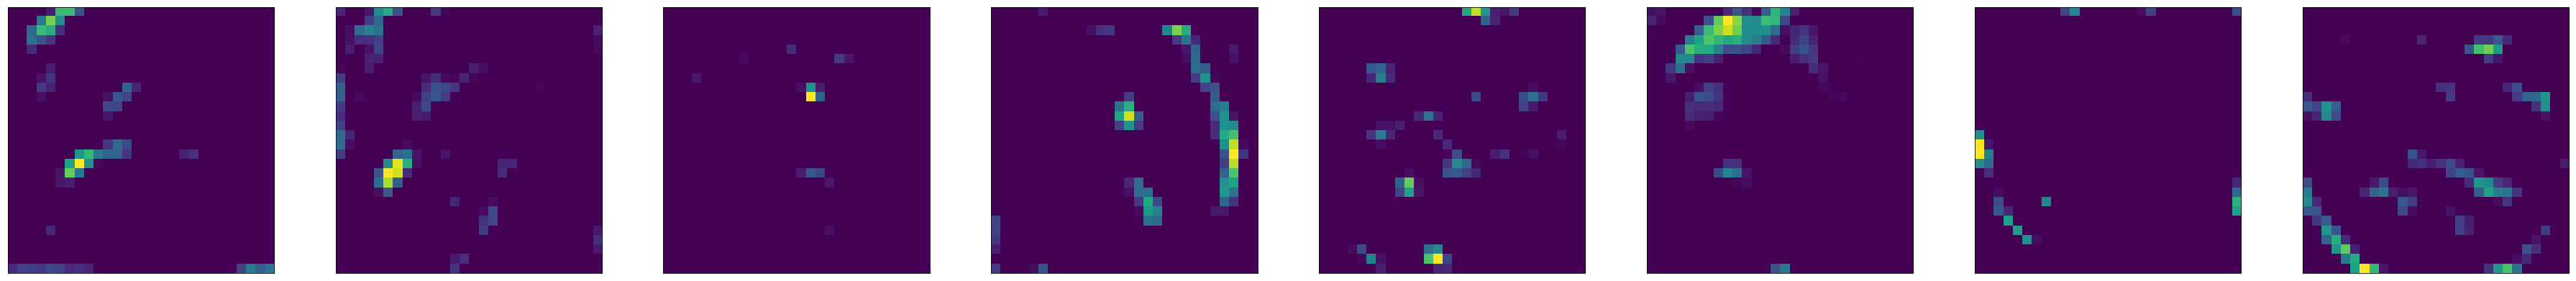

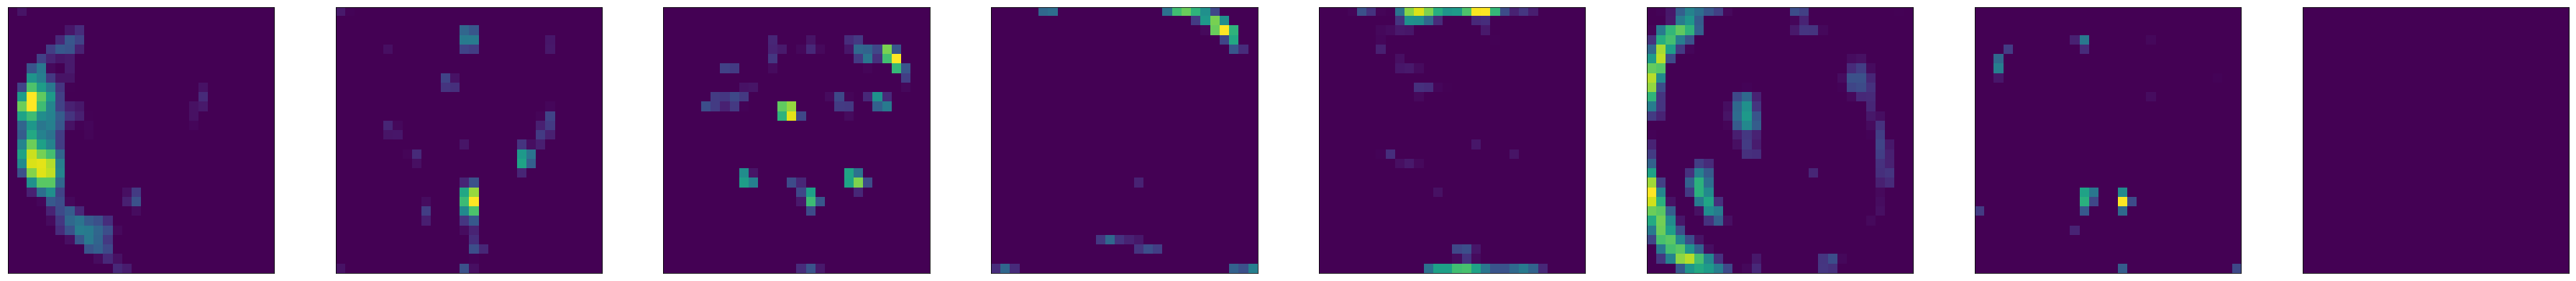

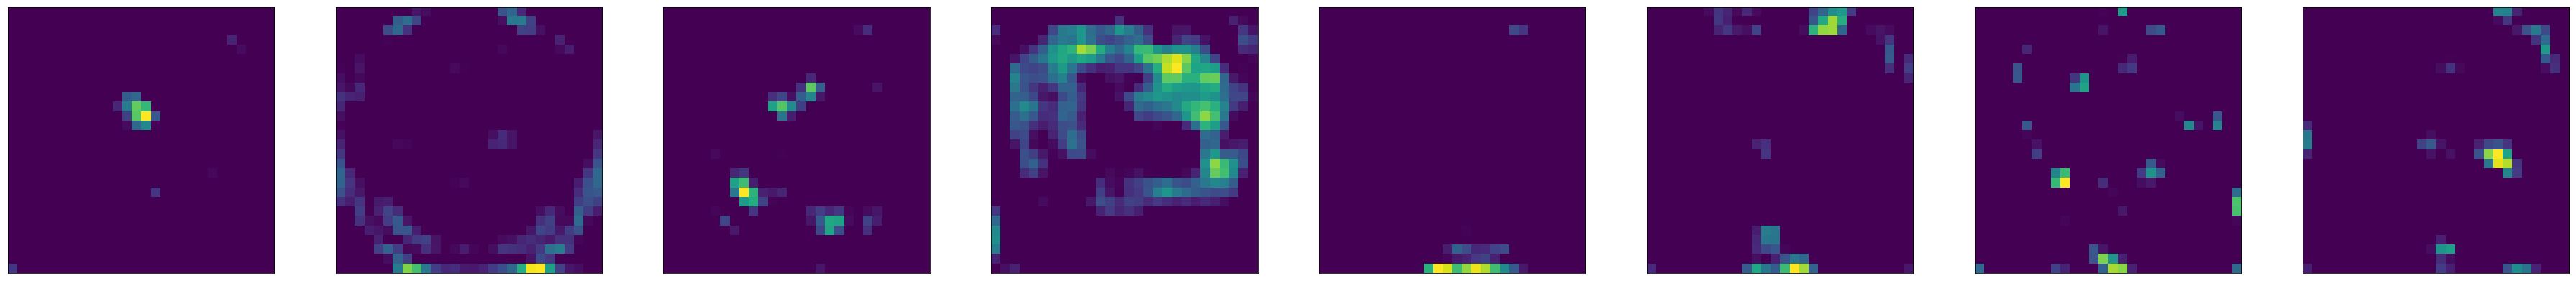

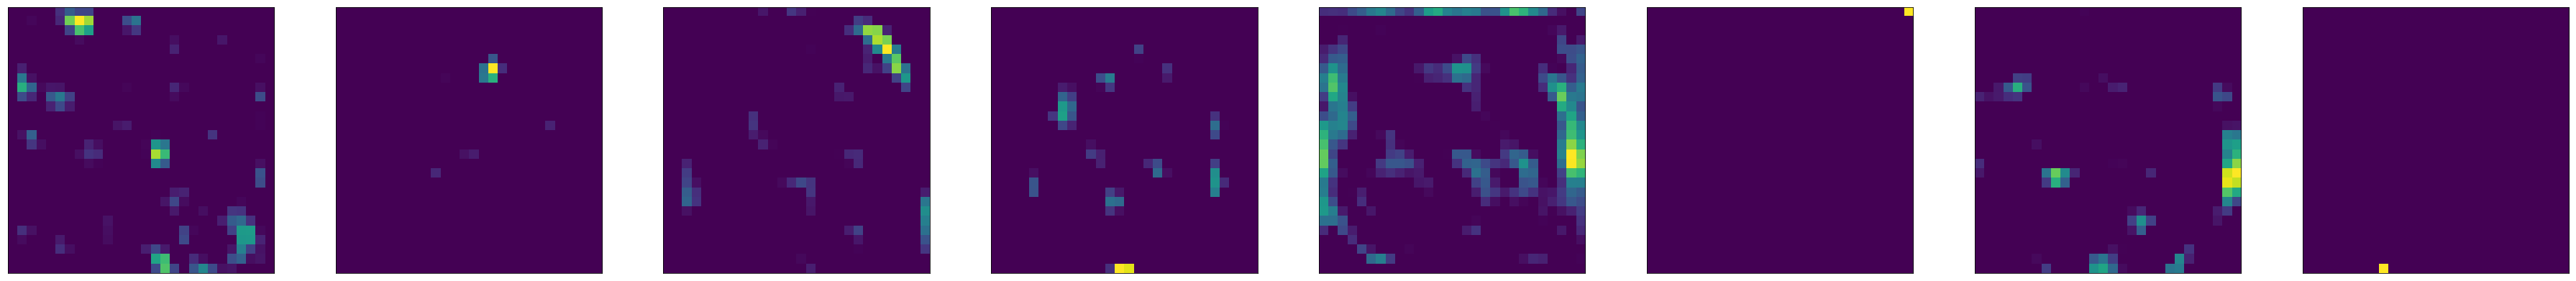

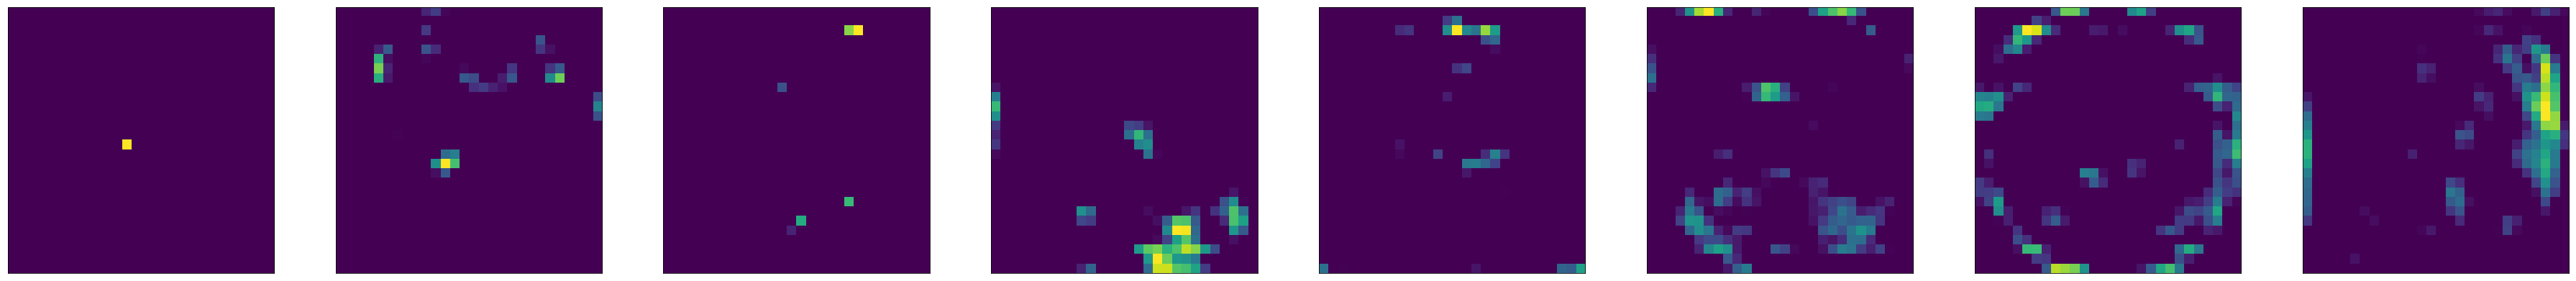

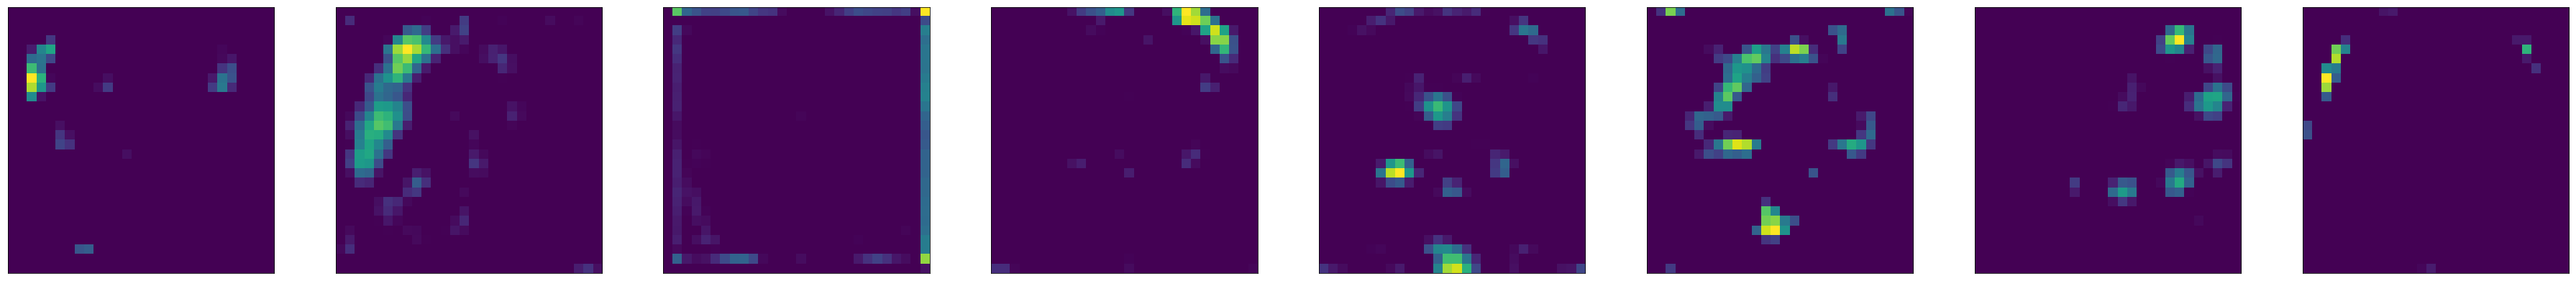

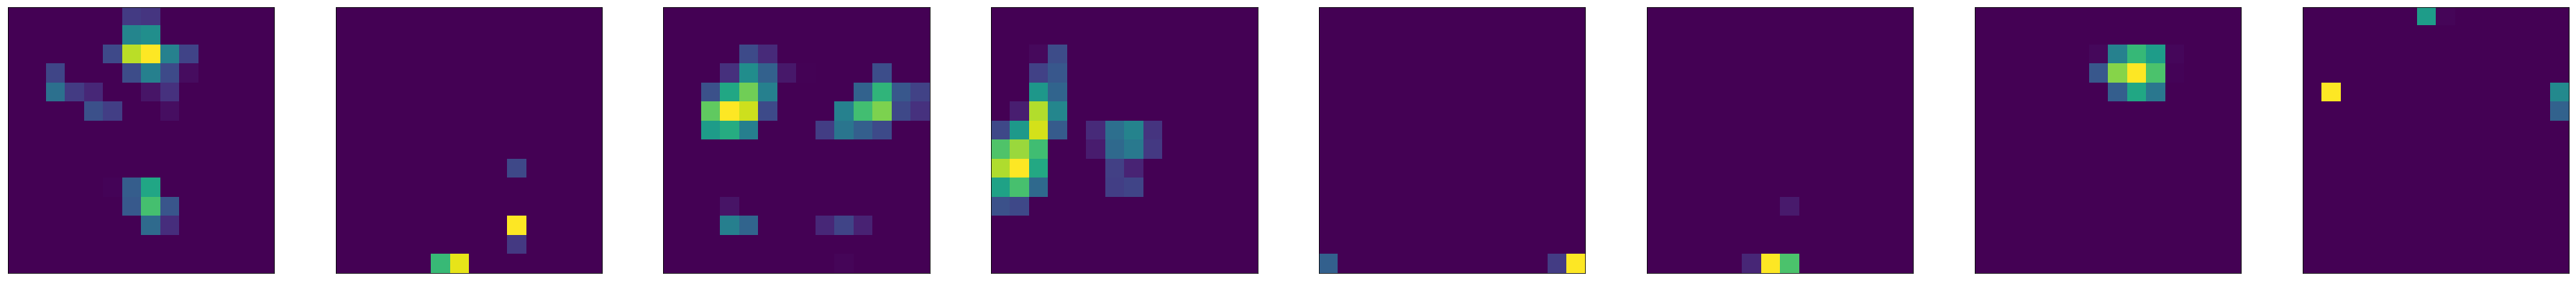

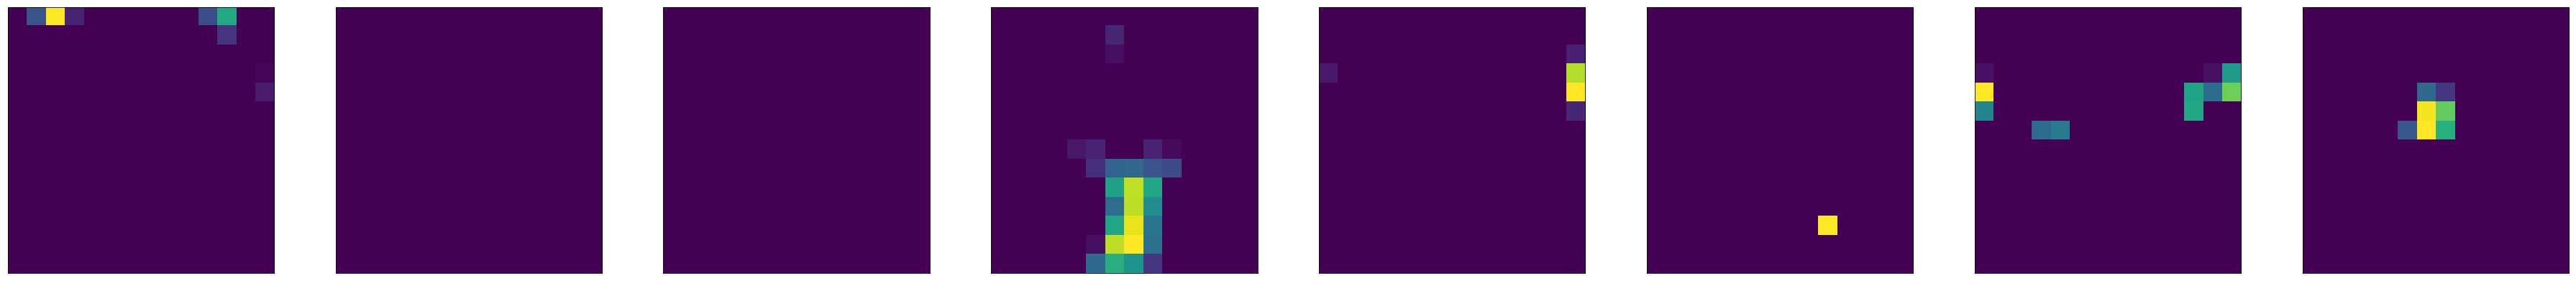

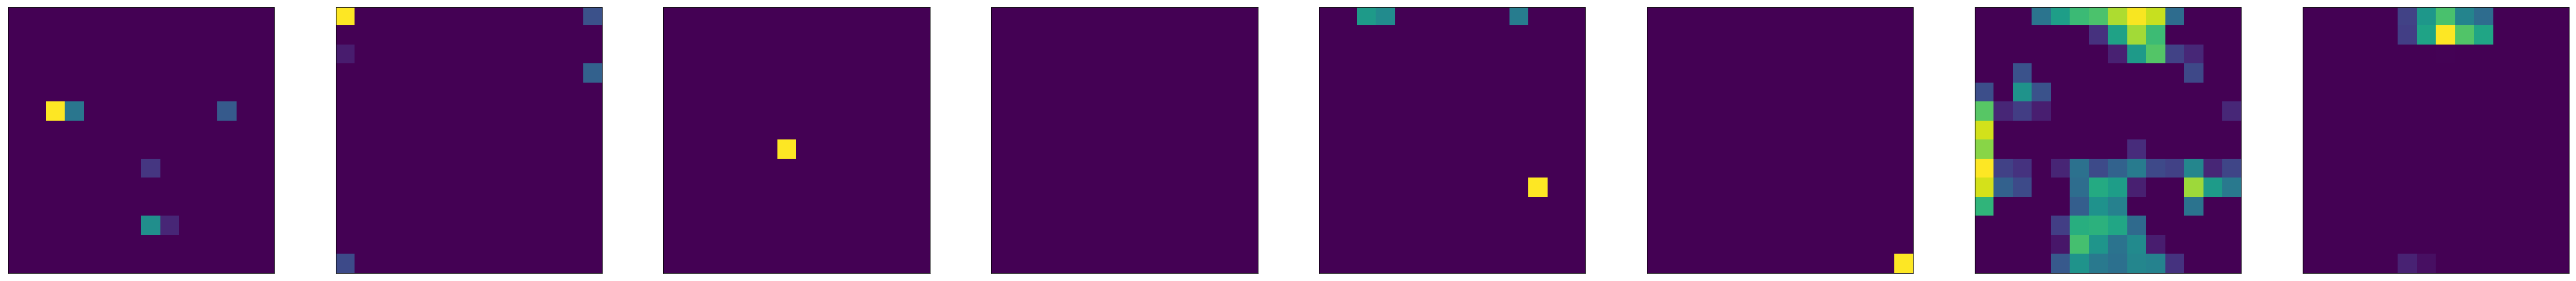

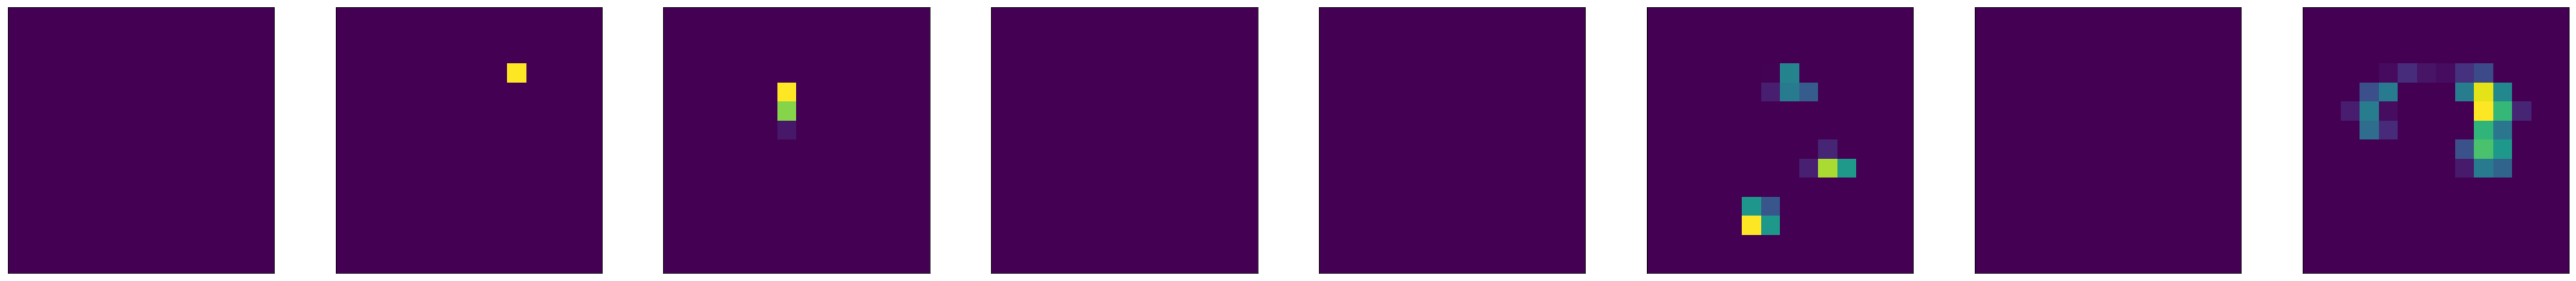

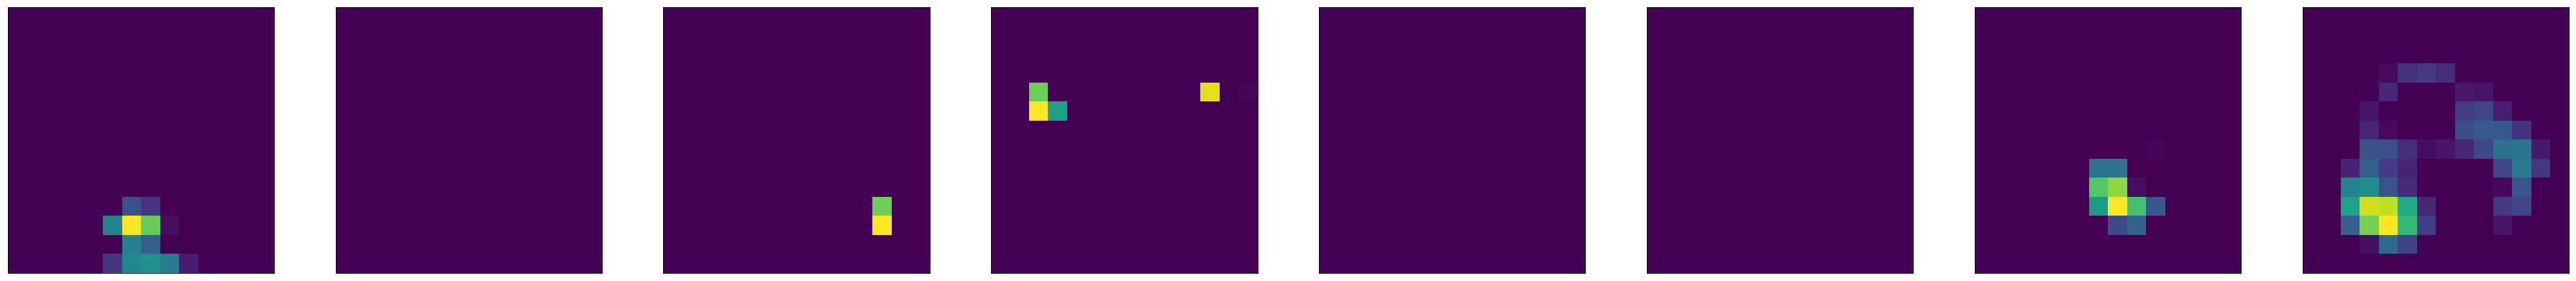

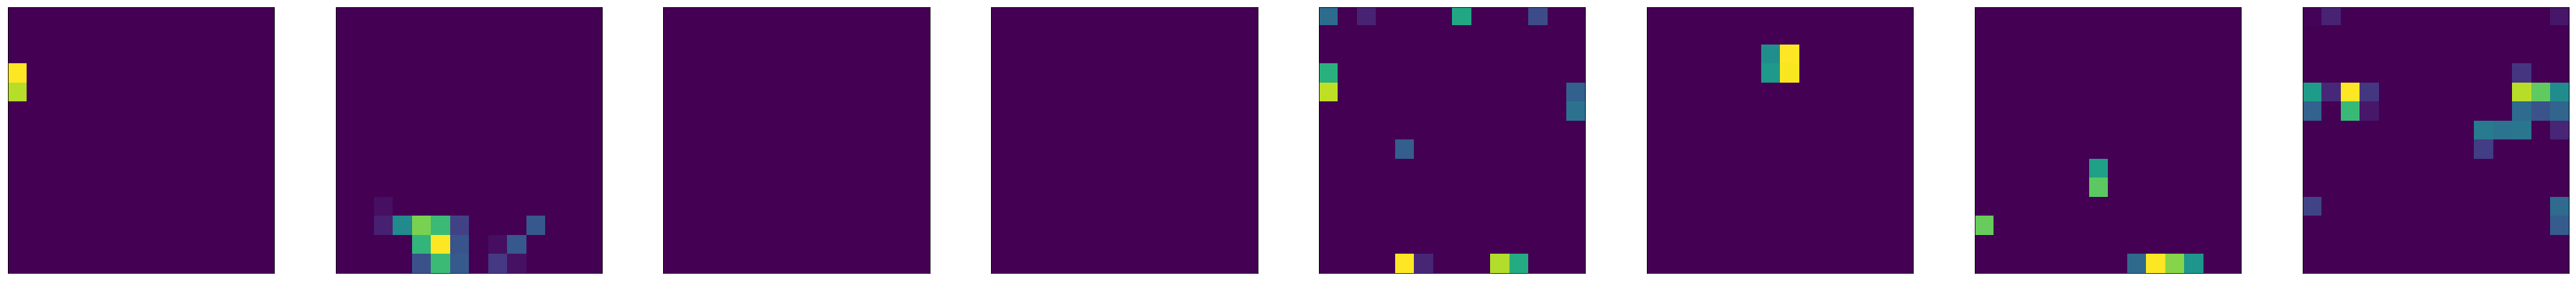

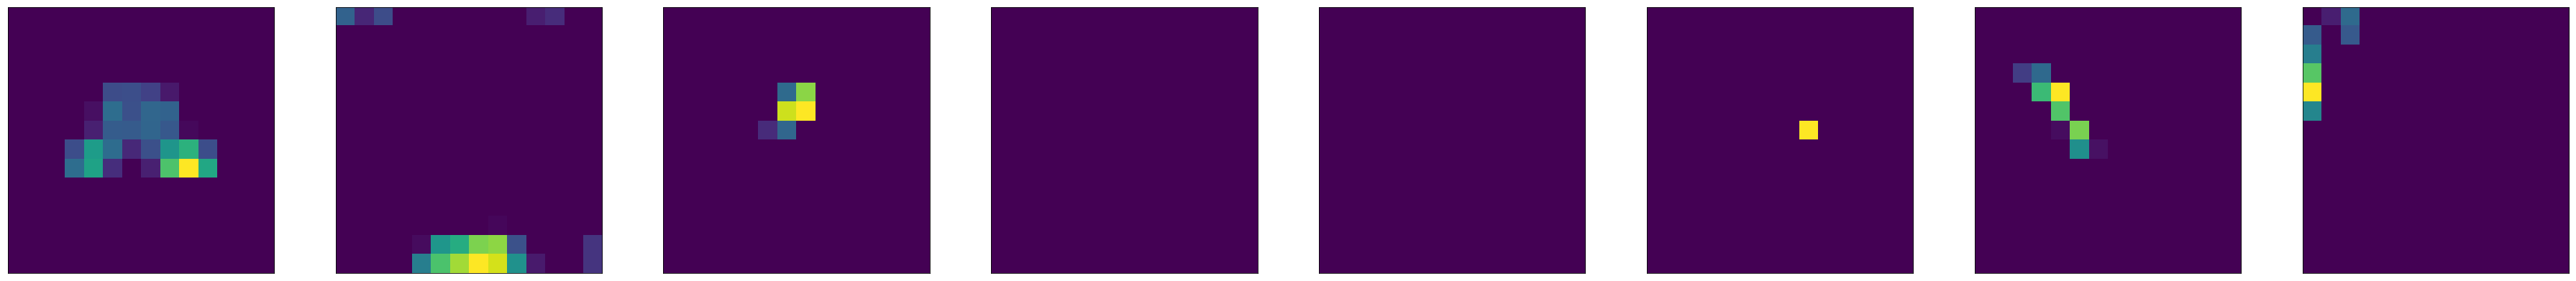

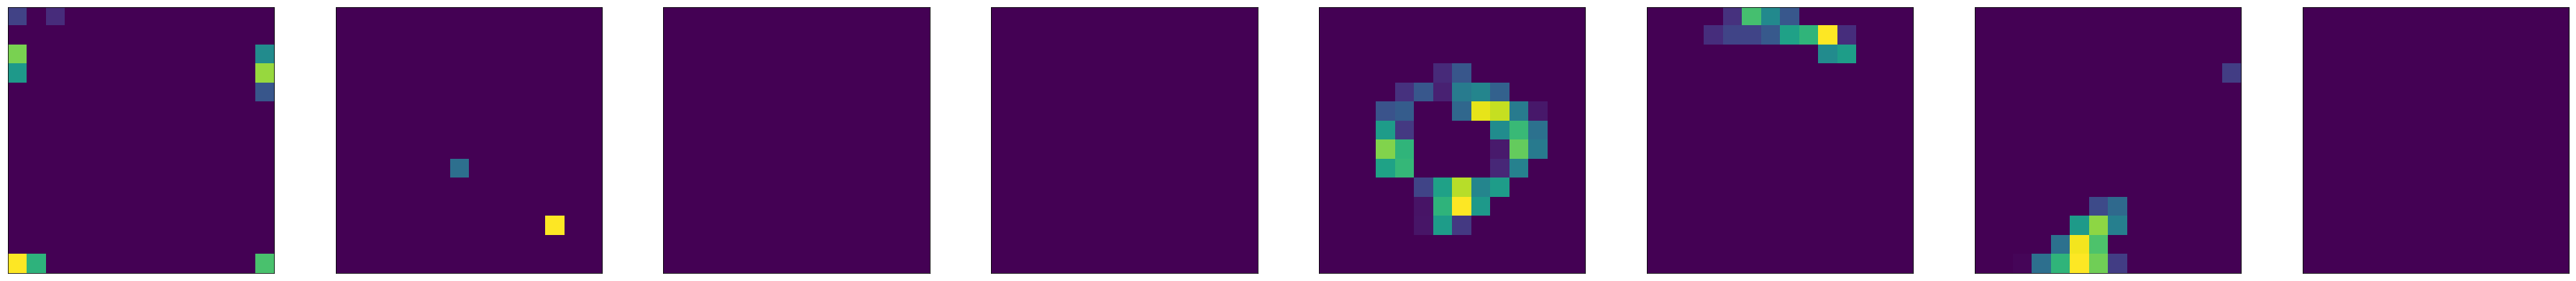

In [34]:
# visualize feature maps output from each block in the vgg model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
import matplotlib.pyplot as plt
from numpy import expand_dims




# load the model
model = VGG16()
# redefine model to output right after the first hidden layer
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
# load the image with the required shape
# convert the image to an array
img = img_to_array(X_val_prep[43])
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot the output from each block
square = 8
for fmap in feature_maps:
	# plot all 64 maps in an 8x8 squares
	ix = 1
	for _ in range(square):
		plt.figure(figsize=(64,64))
		for _ in range(square):
           

			# specify subplot and turn of axis
			ax = pyplot.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			
			# plot filter channel in grayscale
			plt.imshow(fmap[0, :, :, ix-1], cmap='viridis')
			ix += 1
	# show the figure

        
	plt.show()

In [36]:
import time

start = time.time()

vgg16_history = vgg16.fit_generator(
    train_generator,
    steps_per_epoch=45,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=30,
)


end = time.time()
print(end - start)

Epoch 1/30
45/45 [==============================] - 20s 438ms/step - loss: 1.2156 - acc: 0.8805 - val_loss: 1.2747 - val_acc: 0.8822
Epoch 2/30
45/45 [==============================] - 19s 411ms/step - loss: 0.7423 - acc: 0.9241 - val_loss: 1.2582 - val_acc: 0.8750
Epoch 3/30
45/45 [==============================] - 18s 399ms/step - loss: 0.6345 - acc: 0.9366 - val_loss: 0.9853 - val_acc: 0.9031
Epoch 4/30
45/45 [==============================] - 19s 412ms/step - loss: 0.6954 - acc: 0.9225 - val_loss: 1.1735 - val_acc: 0.8804
Epoch 5/30
45/45 [==============================] - 19s 412ms/step - loss: 0.6937 - acc: 0.9331 - val_loss: 1.2537 - val_acc: 0.8796
Epoch 6/30
45/45 [==============================] - 18s 399ms/step - loss: 0.6190 - acc: 0.9282 - val_loss: 1.4334 - val_acc: 0.8614
Epoch 7/30
45/45 [==============================] - 18s 407ms/step - loss: 0.9169 - acc: 0.9148 - val_loss: 1.5021 - val_acc: 0.8560
Epoch 8/30
45/45 [==============================] - 18s 399ms/step - 

## Calculate Metric

In [37]:
# validate on val set
predictions = vgg16.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

_, train_acc = vgg16.evaluate(X_val_prep, y_val, verbose=0)
_, test_acc = vgg16.evaluate(X_test_prep, y_test, verbose=0)

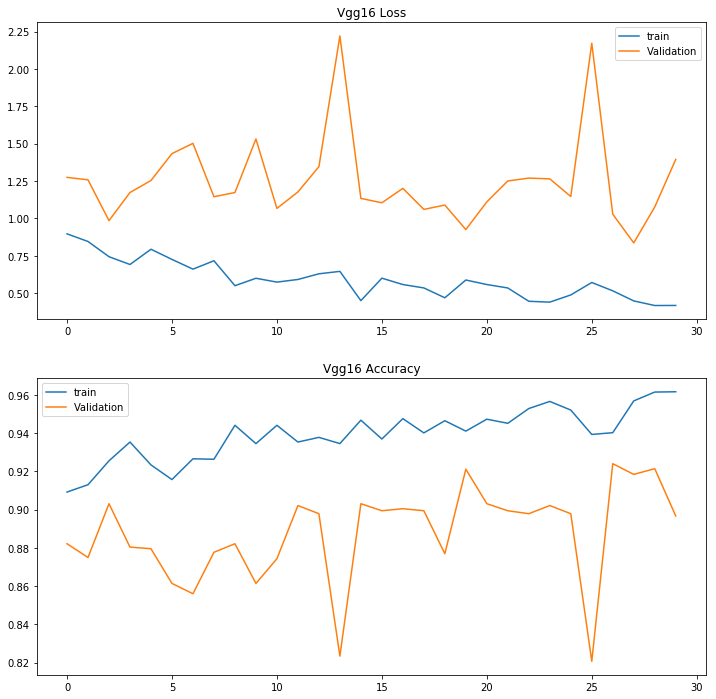

In [38]:
pyplot.figure(figsize=(12,12))
# plot loss during training
pyplot.subplot(211)
pyplot.title('Vgg16 Loss')
pyplot.plot(vgg16_history.history['loss'], label='train')
pyplot.plot(vgg16_history.history['val_loss'], label='Validation')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Vgg16 Accuracy')
pyplot.plot(vgg16_history.history['acc'], label='train')
pyplot.plot(vgg16_history.history['val_acc'], label='Validation')
pyplot.legend()
pyplot.show()

In [39]:
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.900, Test: 0.800


In [40]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predictions)
print('F1 score: %f' % f1)

Accuracy: 0.800000
Precision: 0.800000
Recall: 0.800000
F1 score: 0.800000


In [41]:
kappa = cohen_kappa_score(y_test, predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, predictions)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, predictions)
print(matrix)

Cohens kappa: 0.600000
ROC AUC: 0.800000
[[4 1]
 [1 4]]


# InceptionV3

In [42]:


NUM_CLASSES = 1

inception_v3 = Sequential()
inception_v3.add(inceptionV3)
inception_v3.add(layers.Dropout(0.3))
inception_v3.add(layers.Flatten())
inception_v3.add(layers.Dropout(0.5))
inception_v3.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

inception_v3.layers[0].trainable = False

inception_v3.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

inception_v3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 5, 2048)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 51200)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51201     
Total params: 21,853,985
Trainable params: 51,201
Non-trainable params: 21,802,784
_________________________________________________________________


In [43]:
import time

start = time.time()

inception_v3_history = inception_v3.fit_generator(
    train_generator,
    steps_per_epoch=45,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=30,
)

end = time.time()
print(end - start)

Epoch 1/30
45/45 [==============================] - 25s 547ms/step - loss: 0.7727 - acc: 0.5843 - val_loss: 4.6900 - val_acc: 0.6021
Epoch 2/30
45/45 [==============================] - 15s 331ms/step - loss: 0.6249 - acc: 0.7119 - val_loss: 6.0255 - val_acc: 0.6114
Epoch 3/30
45/45 [==============================] - 18s 402ms/step - loss: 0.6128 - acc: 0.6935 - val_loss: 3.7619 - val_acc: 0.6021
Epoch 4/30
45/45 [==============================] - 18s 394ms/step - loss: 0.4755 - acc: 0.8076 - val_loss: 5.9006 - val_acc: 0.6223
Epoch 5/30
45/45 [==============================] - 18s 398ms/step - loss: 0.5449 - acc: 0.7193 - val_loss: 3.8029 - val_acc: 0.6832
Epoch 6/30
45/45 [==============================] - 18s 401ms/step - loss: 0.5588 - acc: 0.7186 - val_loss: 3.5535 - val_acc: 0.5353
Epoch 7/30
45/45 [==============================] - 17s 388ms/step - loss: 0.4042 - acc: 0.8270 - val_loss: 4.1427 - val_acc: 0.6754
Epoch 8/30
45/45 [==============================] - 18s 401ms/step - 

# RESNET50

In [44]:


NUM_CLASSES = 1

resnet50 = Sequential()
resnet50.add(resnet50_x)
resnet50.add(layers.Dropout(0.3))
resnet50.add(layers.Flatten())
resnet50.add(layers.Dropout(0.5))
resnet50.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

resnet50.layers[0].trainable = False

resnet50.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)
resnet50.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=["accuracy"])

resnet50.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 100353    
Total params: 23,688,065
Trainable params: 100,353
Non-trainable params: 23,587,712
_________________________________________________________________


In [51]:
import time

start = time.time()

resnet50_history = resnet50.fit_generator(
    train_generator,
    steps_per_epoch=45,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=30,
)

end = time.time()
print(end - start)

Epoch 1/30
45/45 [==============================] - 20s 438ms/step - loss: 0.1472 - acc: 0.9784 - val_loss: 2.2224 - val_acc: 0.7745
Epoch 2/30
45/45 [==============================] - 18s 398ms/step - loss: 0.1030 - acc: 0.9587 - val_loss: 1.3216 - val_acc: 0.8979
Epoch 3/30
45/45 [==============================] - 19s 413ms/step - loss: 0.2646 - acc: 0.9497 - val_loss: 2.8979 - val_acc: 0.6875
Epoch 4/30
45/45 [==============================] - 18s 407ms/step - loss: 0.7891 - acc: 0.8752 - val_loss: 2.7581 - val_acc: 0.6859
Epoch 5/30
45/45 [==============================] - 19s 414ms/step - loss: 0.1502 - acc: 0.9784 - val_loss: 1.5140 - val_acc: 0.8370
Epoch 6/30
45/45 [==============================] - 19s 415ms/step - loss: 0.1103 - acc: 0.9798 - val_loss: 1.3239 - val_acc: 0.8848
Epoch 7/30
45/45 [==============================] - 18s 404ms/step - loss: 0.1375 - acc: 0.9749 - val_loss: 1.5485 - val_acc: 0.8533
Epoch 8/30
45/45 [==============================] - 19s 417ms/step - 

# **VGG 19**

In [46]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers

NUM_CLASSES = 1

# Load pre-trained VGG19 model (excluding the top fully connected layers)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base VGG19 model
base_model.trainable = False

# Create a new model on top
vgg19 = Sequential()
vgg19.add(base_model)
vgg19.add(layers.Dropout(0.3))
vgg19.add(layers.Flatten())
vgg19.add(layers.Dropout(0.5))
vgg19.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

# Compile the model
optimizer = optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
vgg19.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Display model summary
vgg19.summary()


80142336/80134624 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [52]:
import time

start = time.time()

vgg19_history = vgg19.fit_generator(
    train_generator,
    steps_per_epoch=45,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=30,
)

end = time.time()
print(end - start)

Epoch 1/30
45/45 [==============================] - 22s 493ms/step - loss: 0.3990 - acc: 0.9522 - val_loss: 0.9632 - val_acc: 0.9398
Epoch 2/30
45/45 [==============================] - 20s 450ms/step - loss: 0.3469 - acc: 0.9526 - val_loss: 0.7015 - val_acc: 0.9215
Epoch 3/30
45/45 [==============================] - 21s 474ms/step - loss: 0.2671 - acc: 0.9601 - val_loss: 1.4019 - val_acc: 0.9398
Epoch 4/30
45/45 [==============================] - 20s 443ms/step - loss: 0.2563 - acc: 0.9673 - val_loss: 1.0321 - val_acc: 0.9215
Epoch 5/30
45/45 [==============================] - 21s 469ms/step - loss: 0.3613 - acc: 0.9601 - val_loss: 0.7179 - val_acc: 0.9215
Epoch 6/30
45/45 [==============================] - 20s 439ms/step - loss: 0.6124 - acc: 0.9640 - val_loss: 2.3573 - val_acc: 0.8220
Epoch 7/30
45/45 [==============================] - 21s 462ms/step - loss: 0.4151 - acc: 0.9530 - val_loss: 1.0616 - val_acc: 0.9058
Epoch 8/30
45/45 [==============================] - 20s 438ms/step - 

## <a id='perf'>4.3. Model Performance</a>

In [53]:
history_1= vgg16_history
history_2=inception_v3_history
history_3=resnet50_history
history_4=vgg19_history

In [54]:
def ModelGraphTrainngSummary(history,N,model_name):
    # set the matplotlib backend so figures can be saved in the background
    # plot the training loss and accuracy
    import sys
    import matplotlib
    print("Generating plots...")
    sys.stdout.flush()
    matplotlib.use("Agg")
    matplotlib.pyplot.style.use("ggplot")
    matplotlib.pyplot.figure()
    matplotlib.pyplot.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    matplotlib.pyplot.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    #matplotlib.pyplot.plot(np.arange(0, N), history.history["acc"], label="train_acc")
    #matplotlib.pyplot.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
    matplotlib.pyplot.title("Training Loss and Accuracy on Brain Tumor Classification")
    matplotlib.pyplot.xlabel("Epoch #")
    matplotlib.pyplot.ylabel("Loss/Accuracy of "+model_name)
    matplotlib.pyplot.legend(loc="lower left")
    matplotlib.pyplot.savefig("plot.png")

In [55]:
def ModelGraphTrainngSummaryAcc(history,N,model_name):
    # set the matplotlib backend so figures can be saved in the background
    # plot the training loss and accuracy
    import sys
    import matplotlib
    print("Generating plots...")
    sys.stdout.flush()
    matplotlib.use("Agg")
    matplotlib.pyplot.style.use("ggplot")
    matplotlib.pyplot.figure()
    #matplotlib.pyplot.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    #matplotlib.pyplot.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    matplotlib.pyplot.plot(np.arange(0, N), history.history["acc"], label="train_acc")
    matplotlib.pyplot.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
    matplotlib.pyplot.title("Training Loss and Accuracy on Brain Tumor Classification")
    matplotlib.pyplot.xlabel("Epoch #")
    matplotlib.pyplot.ylabel("Accuracy of "+ model_name)
    matplotlib.pyplot.legend(loc="lower left")
    matplotlib.pyplot.savefig("plot.png")

Generating plots...
Generating plots...
Val Accuracy = 0.90
Generating plots...
Generating plots...
Val Accuracy = 0.62
Generating plots...
Generating plots...
Val Accuracy = 0.82
Generating plots...
Generating plots...
Val Accuracy = 0.90


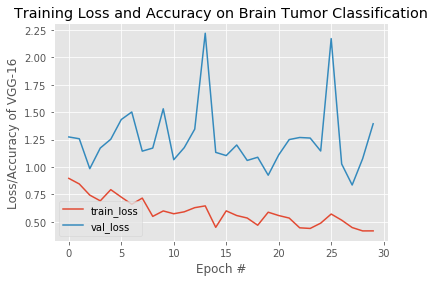

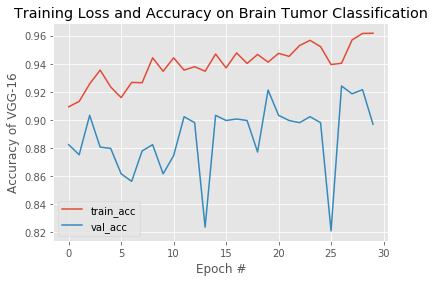

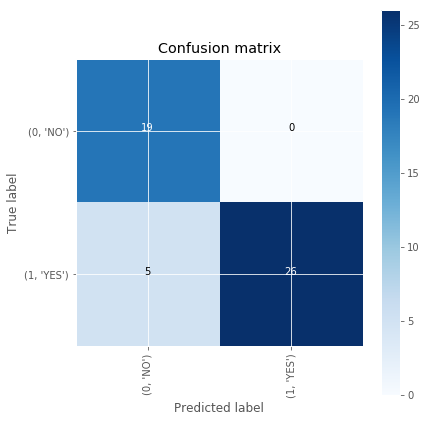

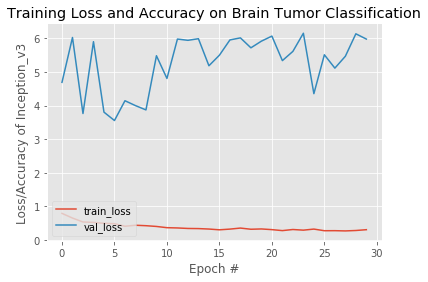

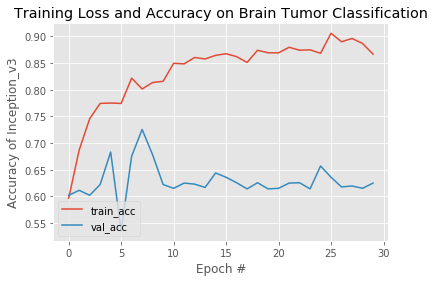

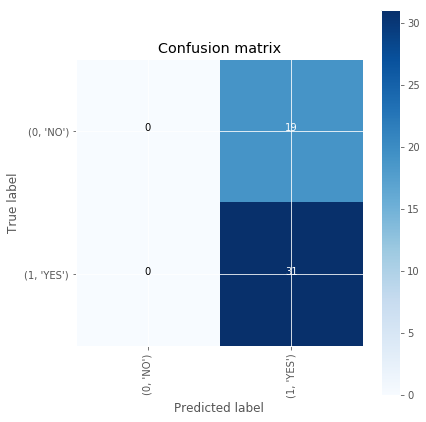

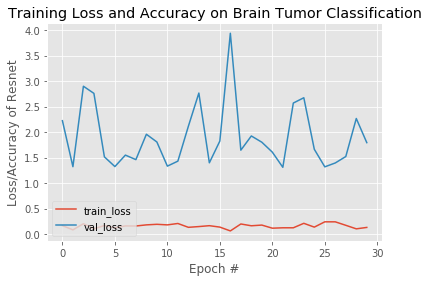

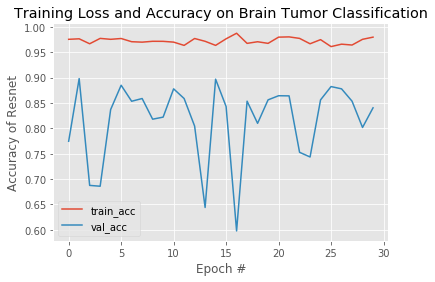

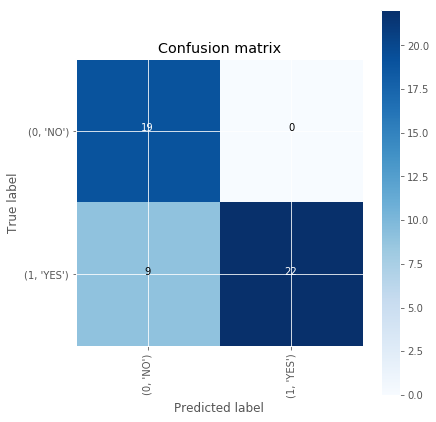

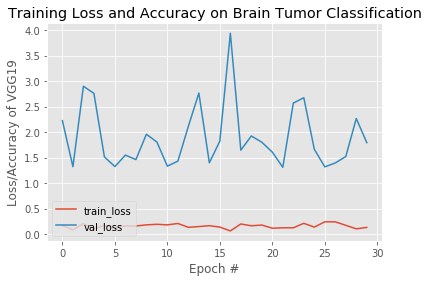

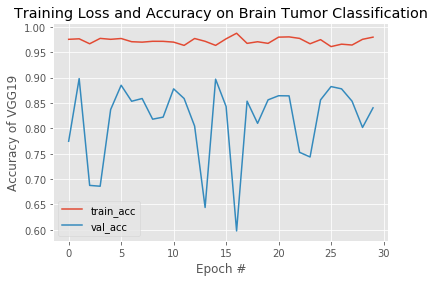

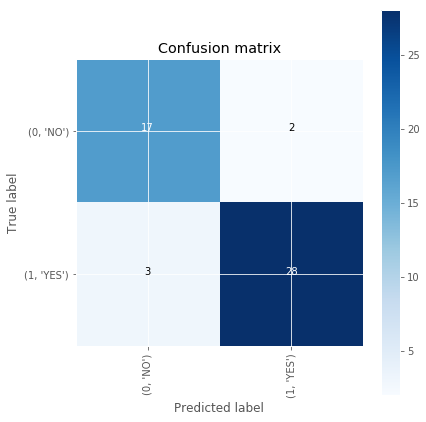

In [56]:
for x_model in [{'name':'VGG-16','history':history_1,'model':vgg16},
                {'name':'Inception_v3','history':history_2,'model':inception_v3},
                {'name':'Resnet','history':history_3,'model':resnet50},
               {'name':'VGG19','history':history_3,'model':vgg19}]:
    ModelGraphTrainngSummary(x_model['history'],30,x_model['name'])
    ModelGraphTrainngSummaryAcc(x_model['history'],30,x_model['name'])
    
    # validate on val set
    predictions = x_model['model'].predict(X_val_prep)
    predictions = [1 if x>0.5 else 0 for x in predictions]

    accuracy = accuracy_score(y_val, predictions)
    print('Val Accuracy = %.2f' % accuracy)

    confusion_mtx = confusion_matrix(y_val, predictions) 
    cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)